# Result processing for master thesis

We want to test 2 things:

- Q1: Can we predict the flipping of a condition:
Can we predict based on a set of metrics IF we will flip a branch (classification in flip or no flip)

- Q2: Is there a strategy which performs better than other strategies:
Can we predict based on a set of metrics WHICH strategy we can use to optimize the time spend on the branch. (regression analysis based on time between strategies)

## Importing data

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

STRATEGIES = ['GradientDescentStrategy', 'MagicByteStrategy' , 'OneByteStrategy', 'LengthTaintStrategy', 'ConcolicStrategy', 'RandomStrategy', 'RandomTaintStrategy']
VARIABLES_TO_TEST = ['oviedo', 'cyclomatic' , 'nrOfOffsets', 'cases', 'chain_size', 'depth2', 'trace_length']
PROGRAMS = ["gif2png", 
"file", "nm", "djpeg", "jhead", "xmlwf", "tcpdump"
]

all_data = []
for program in PROGRAMS:
    print("Reading " + "../results/%s/raw_data.csv" % program)
    program_data = pd.read_csv("../results/%s/raw_data.csv" % program, index_col=False)
    program_data["program"] = program
    all_data.append(program_data)
data = pd.concat(all_data)
#set right types
data["program"] = data["program"].astype('category')
data["status"] = data["status"].astype('category')
data["Strategy"] = data["Strategy"].astype('category')

#add new column
data["relative_depth"] = data["depth2"]/data["trace_length"]
print("done")
data.info()

Reading ../results/gif2png/raw_data.csv
Reading ../results/file/raw_data.csv
Reading ../results/nm/raw_data.csv
Reading ../results/djpeg/raw_data.csv
Reading ../results/jhead/raw_data.csv
Reading ../results/xmlwf/raw_data.csv
Reading ../results/tcpdump/raw_data.csv
done
<class 'pandas.core.frame.DataFrame'>
Int64Index: 373030 entries, 0 to 110445
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   Strategy        373030 non-null  category
 1   id              373030 non-null  object  
 2   cmpid           373030 non-null  int64   
 3   nrOfMisses      373030 non-null  int64   
 4   nrOfInputs      373030 non-null  int64   
 5   depth           373030 non-null  int64   
 6   status          373030 non-null  category
 7   totalTime       373030 non-null  float64 
 8   nrOfOffsets     373030 non-null  int64   
 9   cyclomatic      373030 non-null  object  
 10  oviedo          373030 non-null  object  
 11  ch

In [3]:
data.groupby(["program"]).describe()

cmpid                                                         \
            count          mean           std          min           25%   
program                                                                    
djpeg      3577.0  2.166134e+09  7.874457e+08  611337383.0  1.903821e+09   
file      29778.0  2.604965e+09  1.111522e+09   38470707.0  1.750991e+09   
gif2png    3997.0  2.830103e+08  6.156256e+08   98897100.0  9.891462e+07   
jhead      7343.0  3.154597e+09  6.339629e+08  610160718.0  3.307622e+09   
nm       140091.0  1.737491e+09  7.747063e+08   63528831.0  1.452850e+09   
tcpdump  110446.0  1.930196e+09  1.023299e+09    1371024.0  1.282170e+09   
xmlwf     77798.0  2.246646e+09  1.092970e+09   47579087.0  1.229512e+09   

                                                  nrOfMisses              ...  \
                  50%           75%           max      count        mean  ...   
program                                                                   ...   
djpeg    1.903842e+09  1.903878e+09  4.249747e+09     3577.0  202.668158  ...   
file     3.219363e+09  3.491157e+09  4.269747e+09    29778.0  579.301531  ...   
gif2png  9.892838e+07  9.896003e+07  3.422579e+09     3997.0  421.534651  ...   
jhead    3.307644e+09  3.307668e+09  4.243289e+09     7343.0  209.916928  ...   
nm       1.693393e+09  2.355263e+09  4.223215e+09   140091.0  454.546823  ...   
tcpdump  1.859036e+09  2.541072e+09  4.288922e+09   110446.0  407.708373  ...   
xmlwf    2.511150e+09  3.238476e+09  4.130884e+09    77798.0  569.972429  ...   

        reachableness          relative_depth                           \
                  75%      max          count      mean       std  min   
program                                                                  
djpeg             2.0    272.0         3577.0  0.848772  0.147670  0.0   
file             40.0   4358.0        29778.0  0.488131  0.308479  0.0   
gif2png           8.0    243.0         3997.0  0.773417  0.254703  0.0   
jhead          3586.0  12840.0         7343.0  0.550608  0.274634  0.0   
nm             1346.0  31184.0       140091.0  0.699881  0.233462  0.0   
tcpdump         237.0   7720.0       110446.0  0.548443  0.331042  0.0   
xmlwf             2.0  58045.0        77798.0  0.845426  0.195588  0.0   

                                                 
              25%       50%       75%       max  
program                                          
djpeg    0.740196  0.916084  0.958333  0.995434  
file     0.239331  0.366145  0.803448  0.999532  
gif2png  0.600000  0.914980  0.972789  0.998175  
jhead    0.327062  0.538217  0.842105  0.995961  
nm       0.512786  0.731288  0.919448  0.999743  
tcpdump  0.312233  0.407867  0.949219  0.999929  
xmlwf    0.826955  0.888252  0.982625  0.999890  

[7 rows x 88 columns]

## Inspect data

We will look at the number of flips per strategy per binary

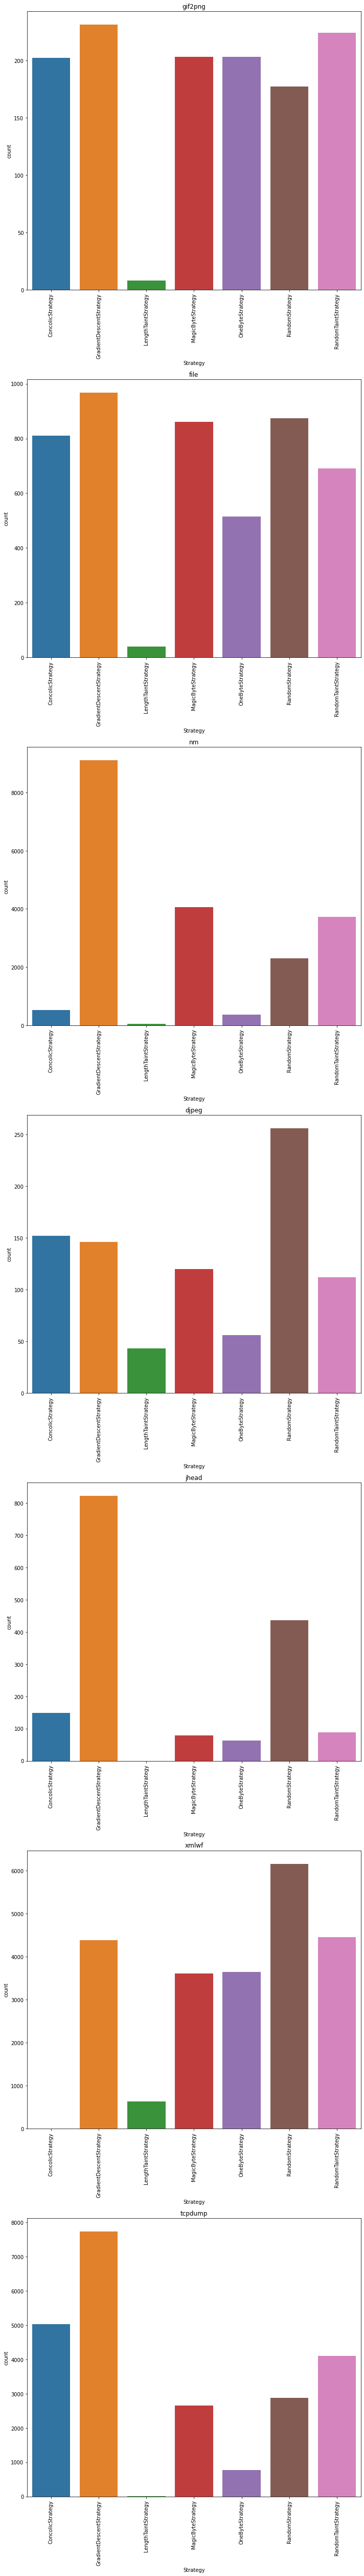

In [4]:

df = data
programs = df.program.unique()
fig, axs = plt.subplots(nrows=int(programs.size), ncols=1, figsize =(10, df["Strategy"].unique().size*10))
axs = axs.flatten()
for ax, program in zip(axs,programs):
    ax = sns.countplot(x="Strategy", data=df[ (df["program"] == program) & (df["flipped"] == 1)], order=df.Strategy.cat.categories,  ax=ax)
    ax.set_xticklabels(df.Strategy.cat.categories, rotation = 90)
    ax.set_title(program)
plt.tight_layout()

### Look at the relations between the variables
We will filter the values of - from the data and try to see some relations

In [5]:
columns = ['relative_depth', 'program', 'flipped', 'id', 'Strategy', 'reachableness', 'totalTime']
columns += VARIABLES_TO_TEST
df_copy = df[columns].copy()
for column in columns:
    df_copy = df_copy[df_copy[column] != '-']
programs = df_copy.program.unique()
for variable in ['oviedo', 'cyclomatic', 'cases', 'chain_size']:
    df_copy[variable] = df_copy[variable].astype('int')
var_names = columns.copy()
var_names.remove("program")
var_names.remove("id")
var_names.remove("Strategy")
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316400 entries, 0 to 110445
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   relative_depth  316400 non-null  float64 
 1   program         316400 non-null  category
 2   flipped         316400 non-null  int64   
 3   id              316400 non-null  object  
 4   Strategy        316400 non-null  category
 5   reachableness   316400 non-null  int64   
 6   totalTime       316400 non-null  float64 
 7   oviedo          316400 non-null  int64   
 8   cyclomatic      316400 non-null  int64   
 9   nrOfOffsets     316400 non-null  int64   
 10  cases           316400 non-null  int64   
 11  chain_size      316400 non-null  int64   
 12  depth2          316400 non-null  int64   
 13  trace_length    316400 non-null  int64   
dtypes: category(2), float64(2), int64(9), object(1)
memory usage: 32.0+ MB


In [6]:
df_copy.sort_values(["Strategy", "id"])
strategies = df_copy.Strategy.unique()
df_grouped = df_copy[df_copy["Strategy"] == strategies[0]].copy()
df_grouped = df_grouped.reset_index(drop=True)
#print(df_grouped.head(1))
#print(df_grouped.tail(1))
for strategy in strategies:
    df_temp = df_copy[df_copy["Strategy"] == strategy].copy().reset_index(drop=True)
    #print(df_temp.head(1))
    #print(df_temp.tail(1))
    df_grouped.flipped |= df_temp.flipped
print(df_grouped.head(8))

   relative_depth  program  flipped                       id  \
0        0.716904  gif2png        0    98922675_790838_0_288   
1        0.983333  gif2png        1      98927229_35617_1_32   
2        0.983806  gif2png        1     98927229_168856_0_32   
3        0.923077  gif2png        1    98912808_145288_0_288   
4        0.949275  gif2png        1     98927229_357687_1_32   
5        0.978632  gif2png        1     98909640_289905_1_32   
6        0.976471  gif2png        1    98922675_193050_1_288   
7        0.995546  gif2png        1  98909640_168856_1_32771   

                  Strategy  reachableness  totalTime  oviedo  cyclomatic  \
0  GradientDescentStrategy            107   0.723659      85          10   
1  GradientDescentStrategy              1   0.171847      32           4   
2  GradientDescentStrategy              1   0.002650      32           4   
3  GradientDescentStrategy              7   0.046333      85          10   
4  GradientDescentStrategy              1  

MemoryError: Unable to allocate 37.6 GiB for an array with shape (301623, 16743) and data type float64

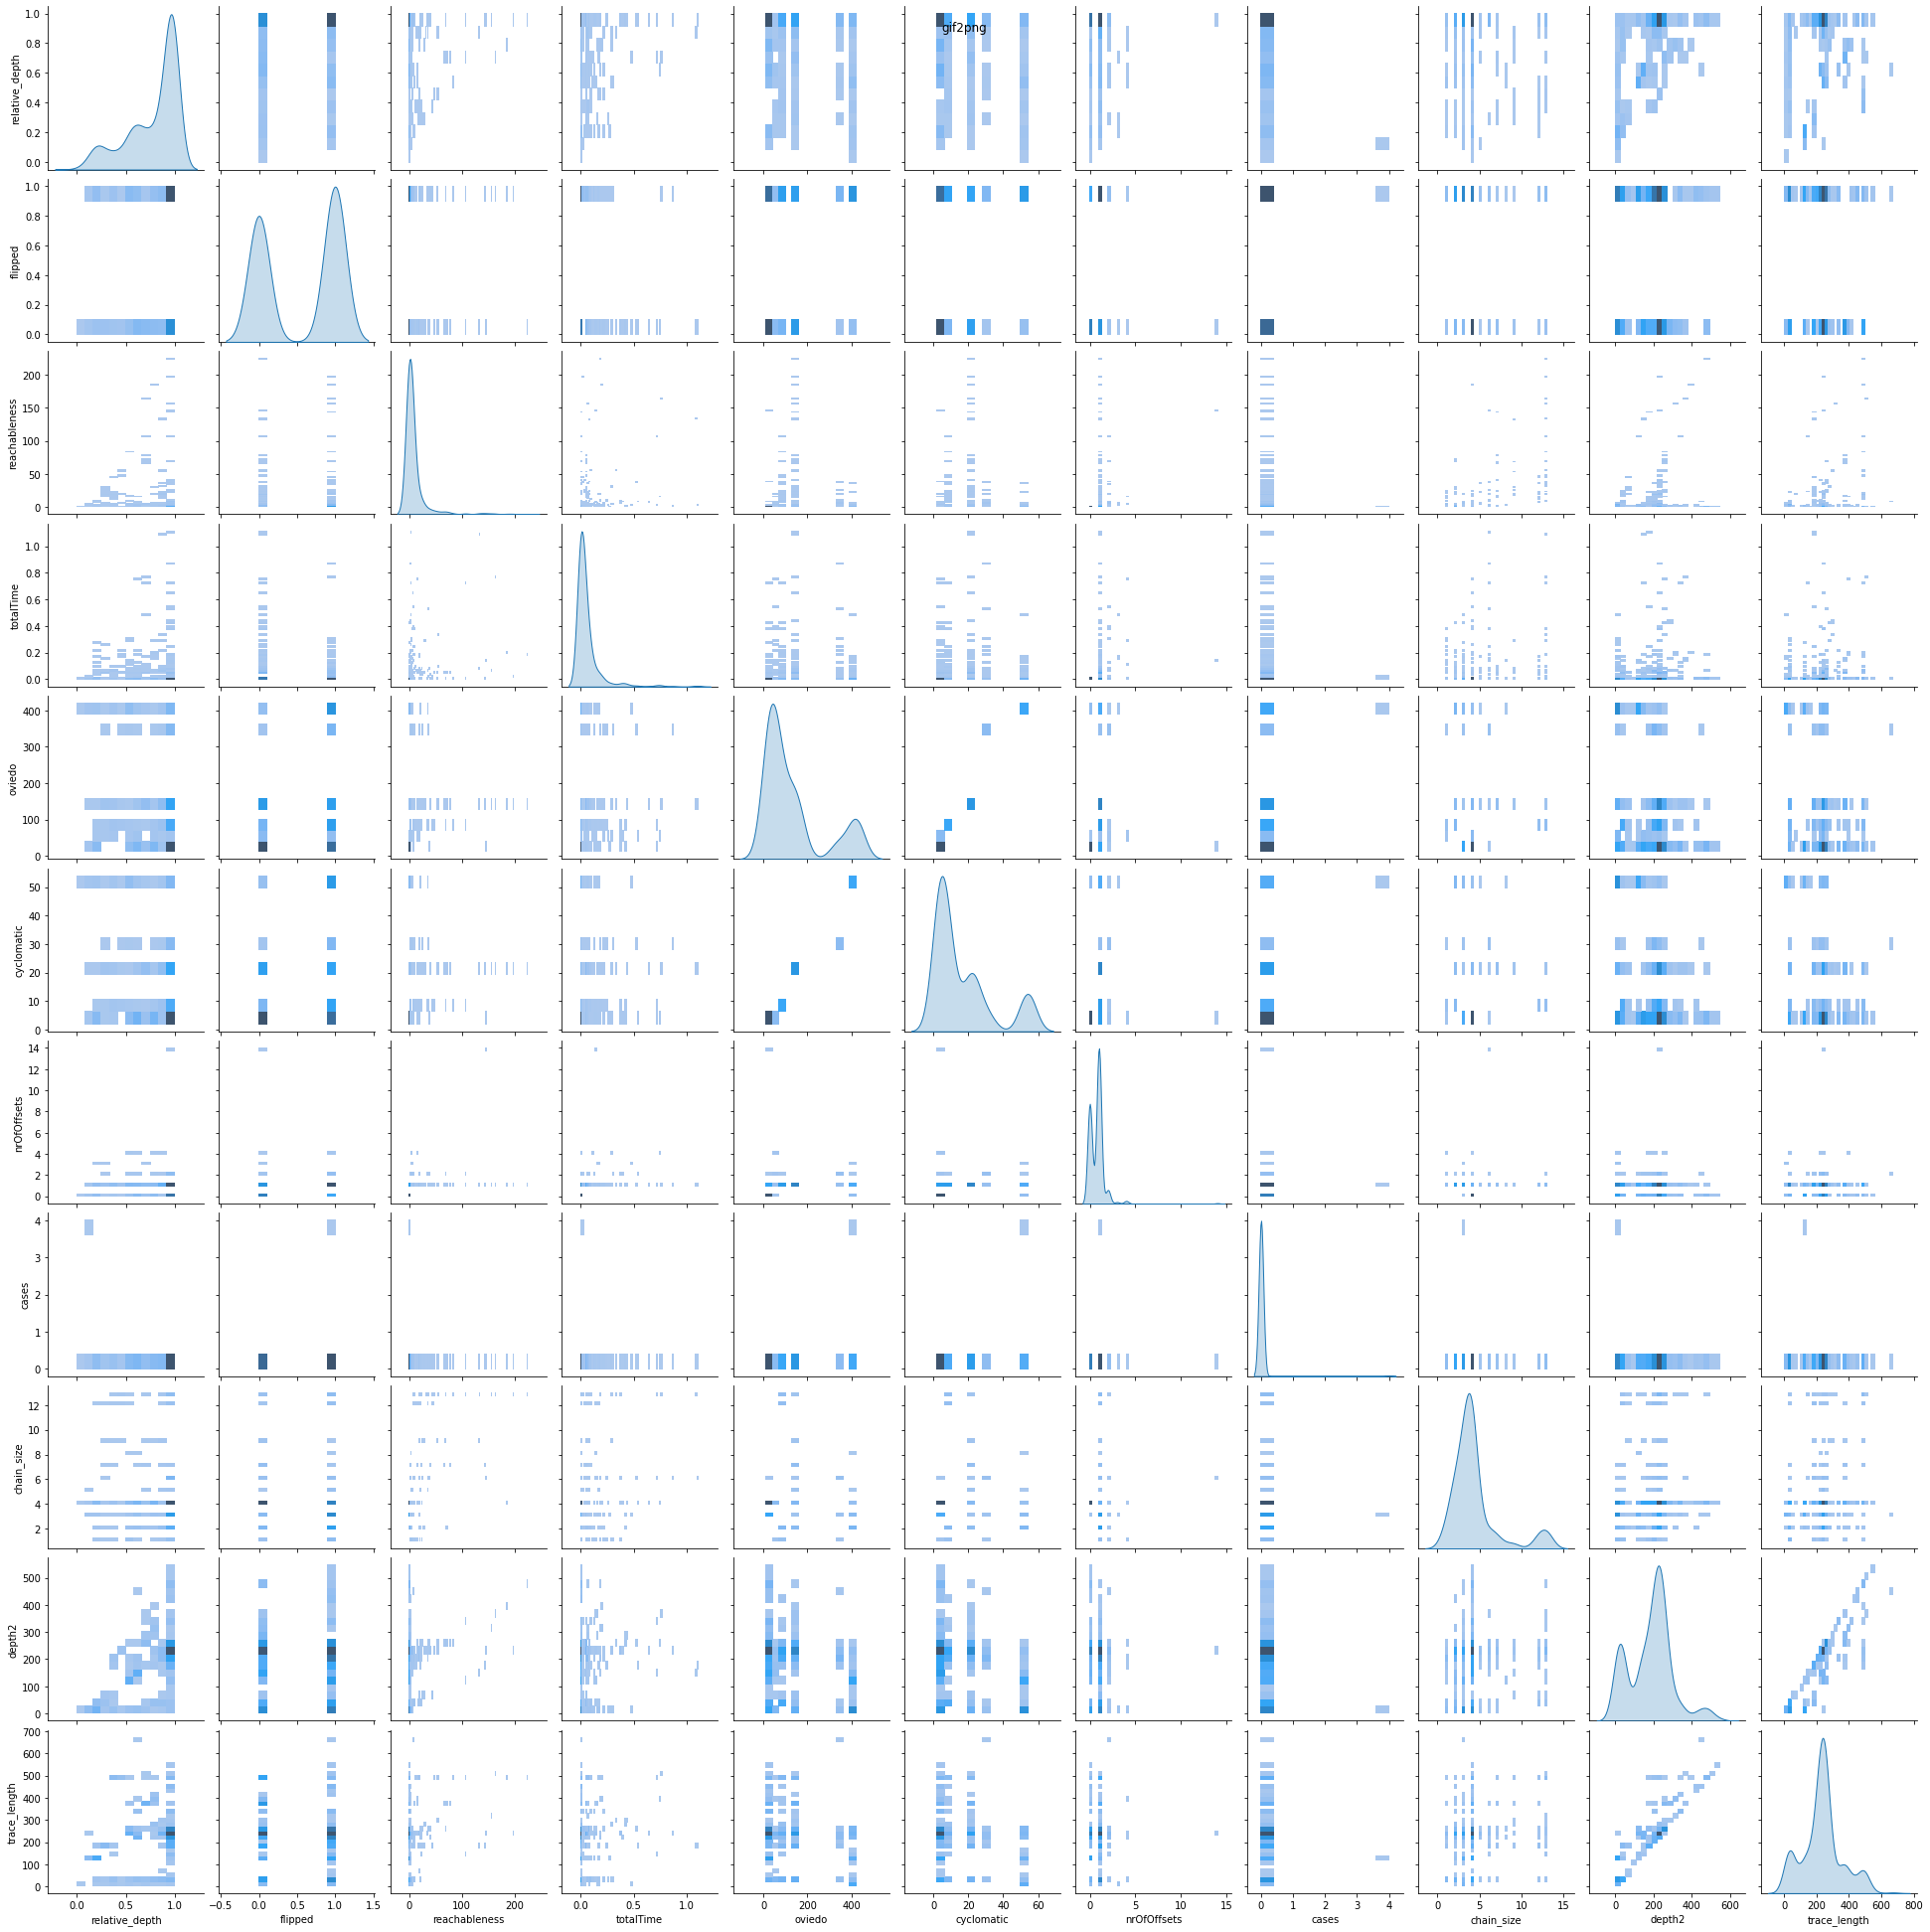

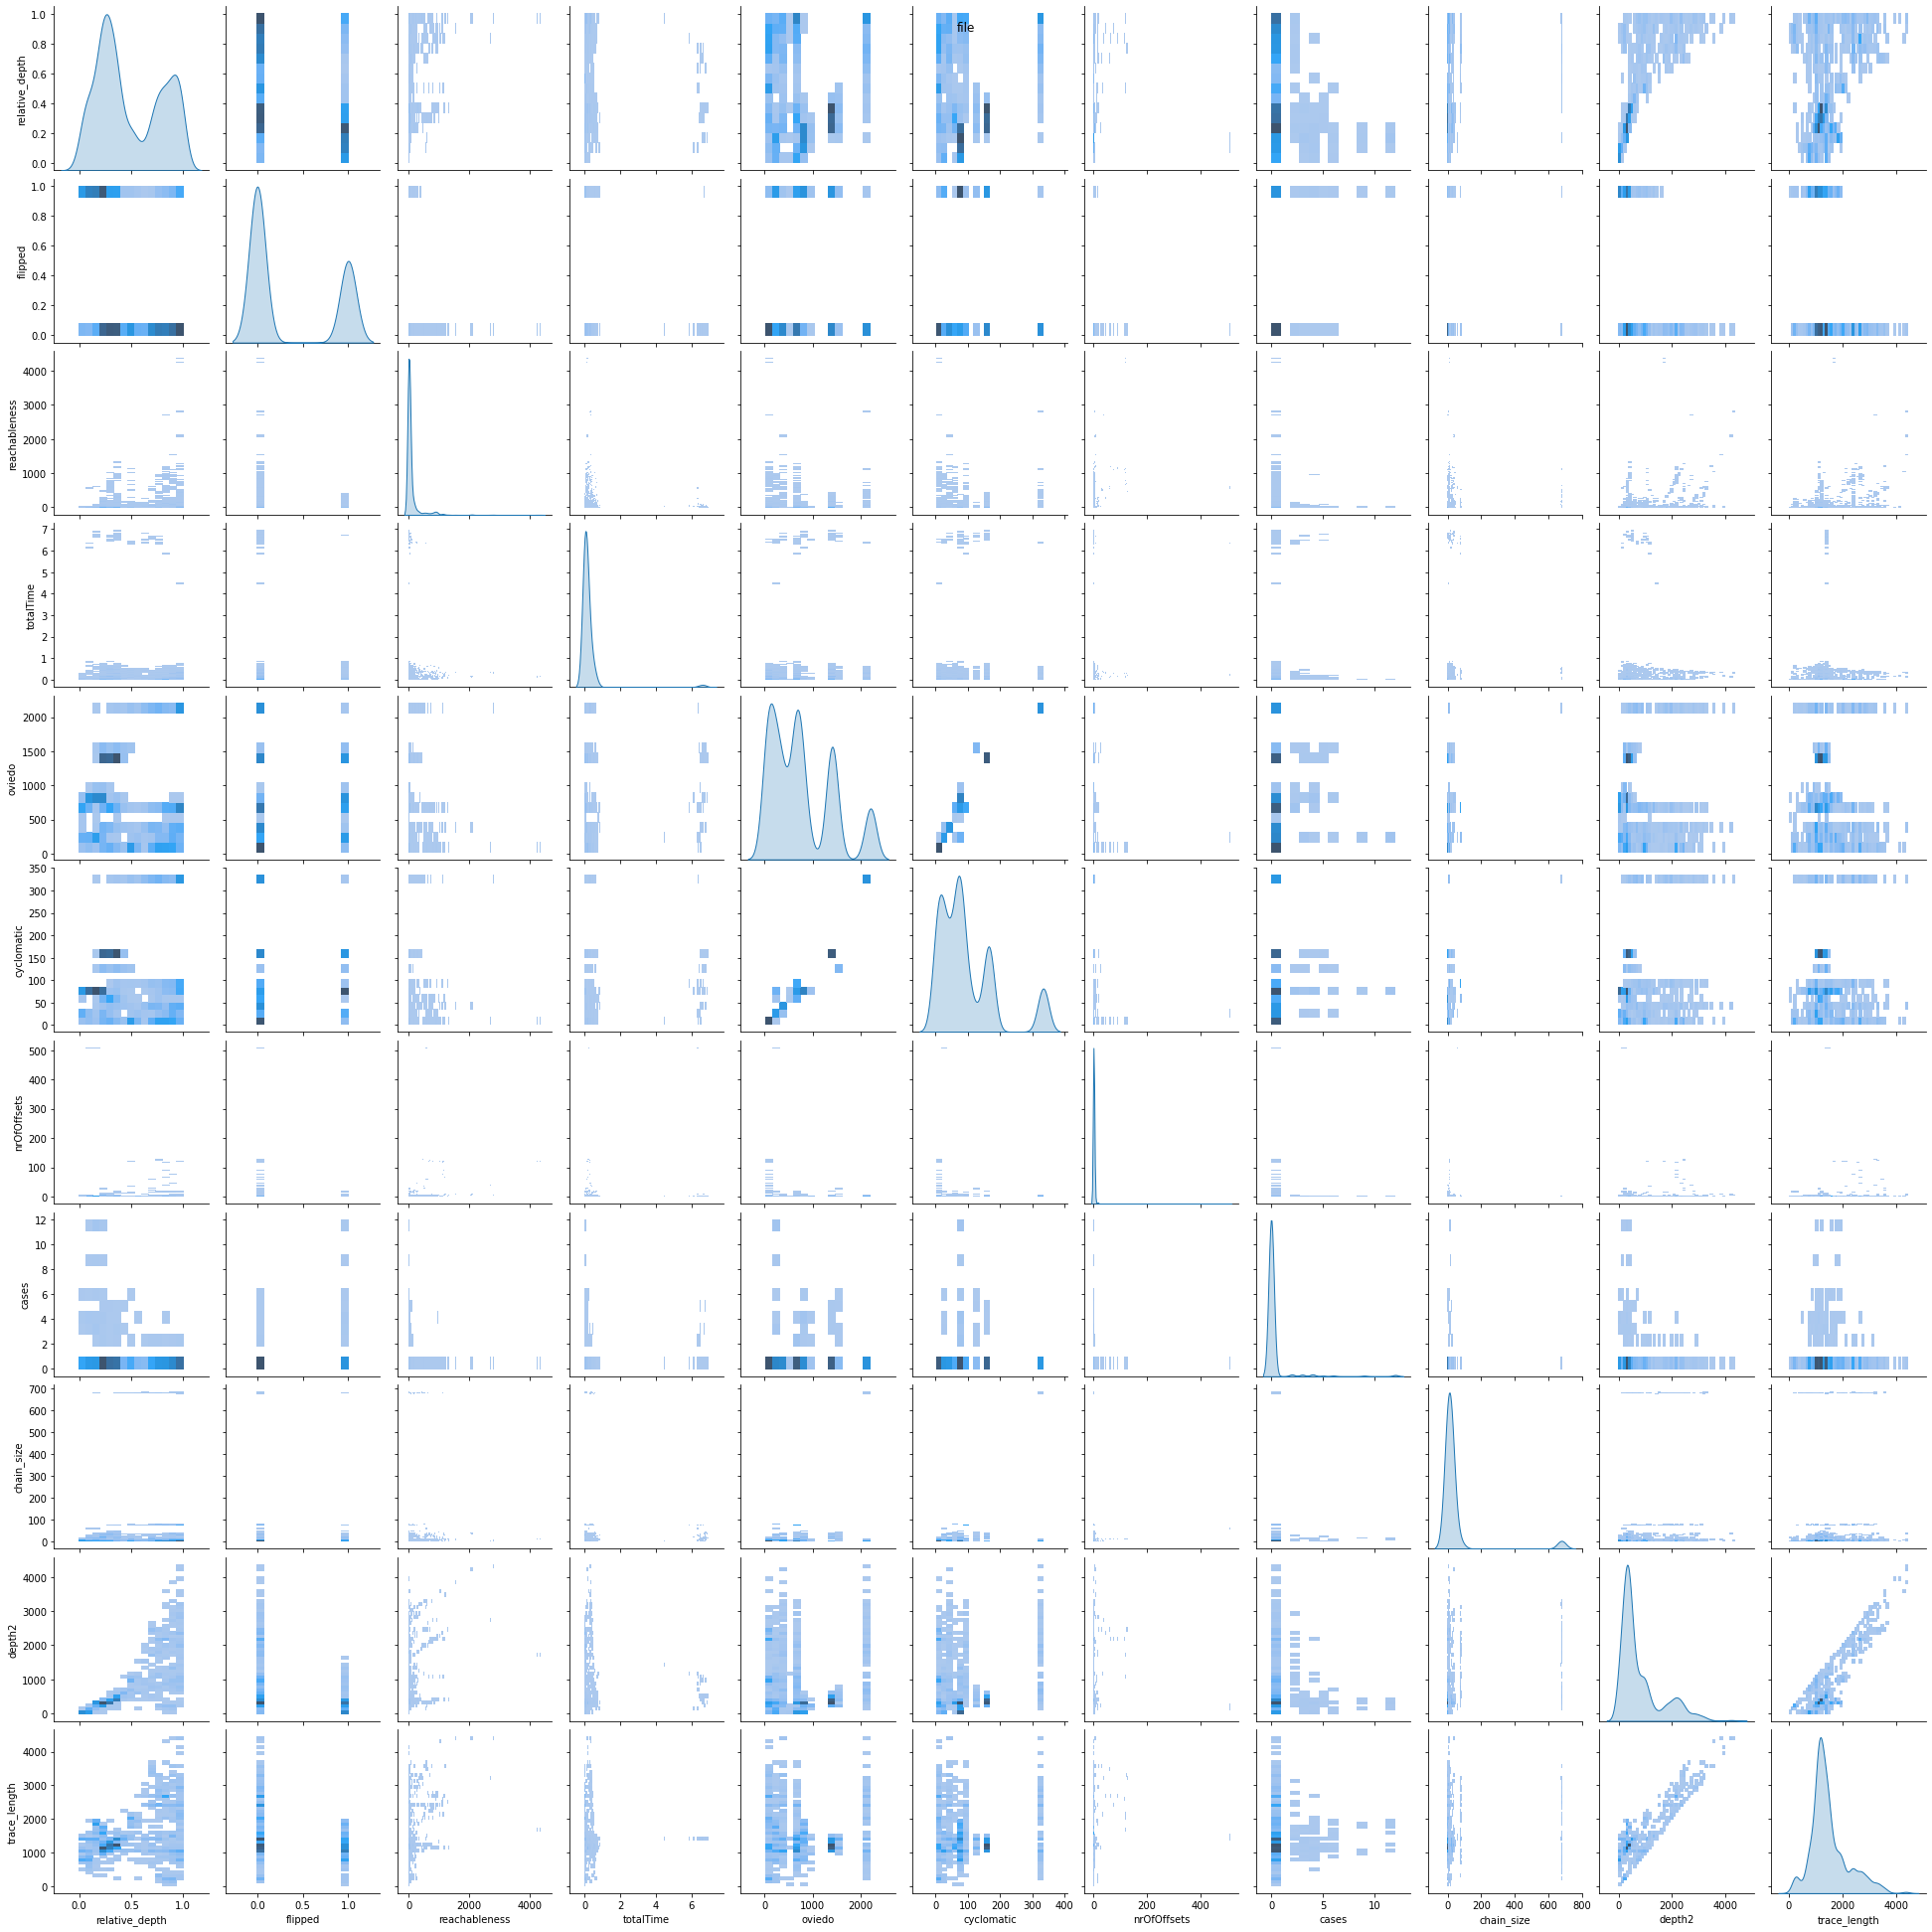

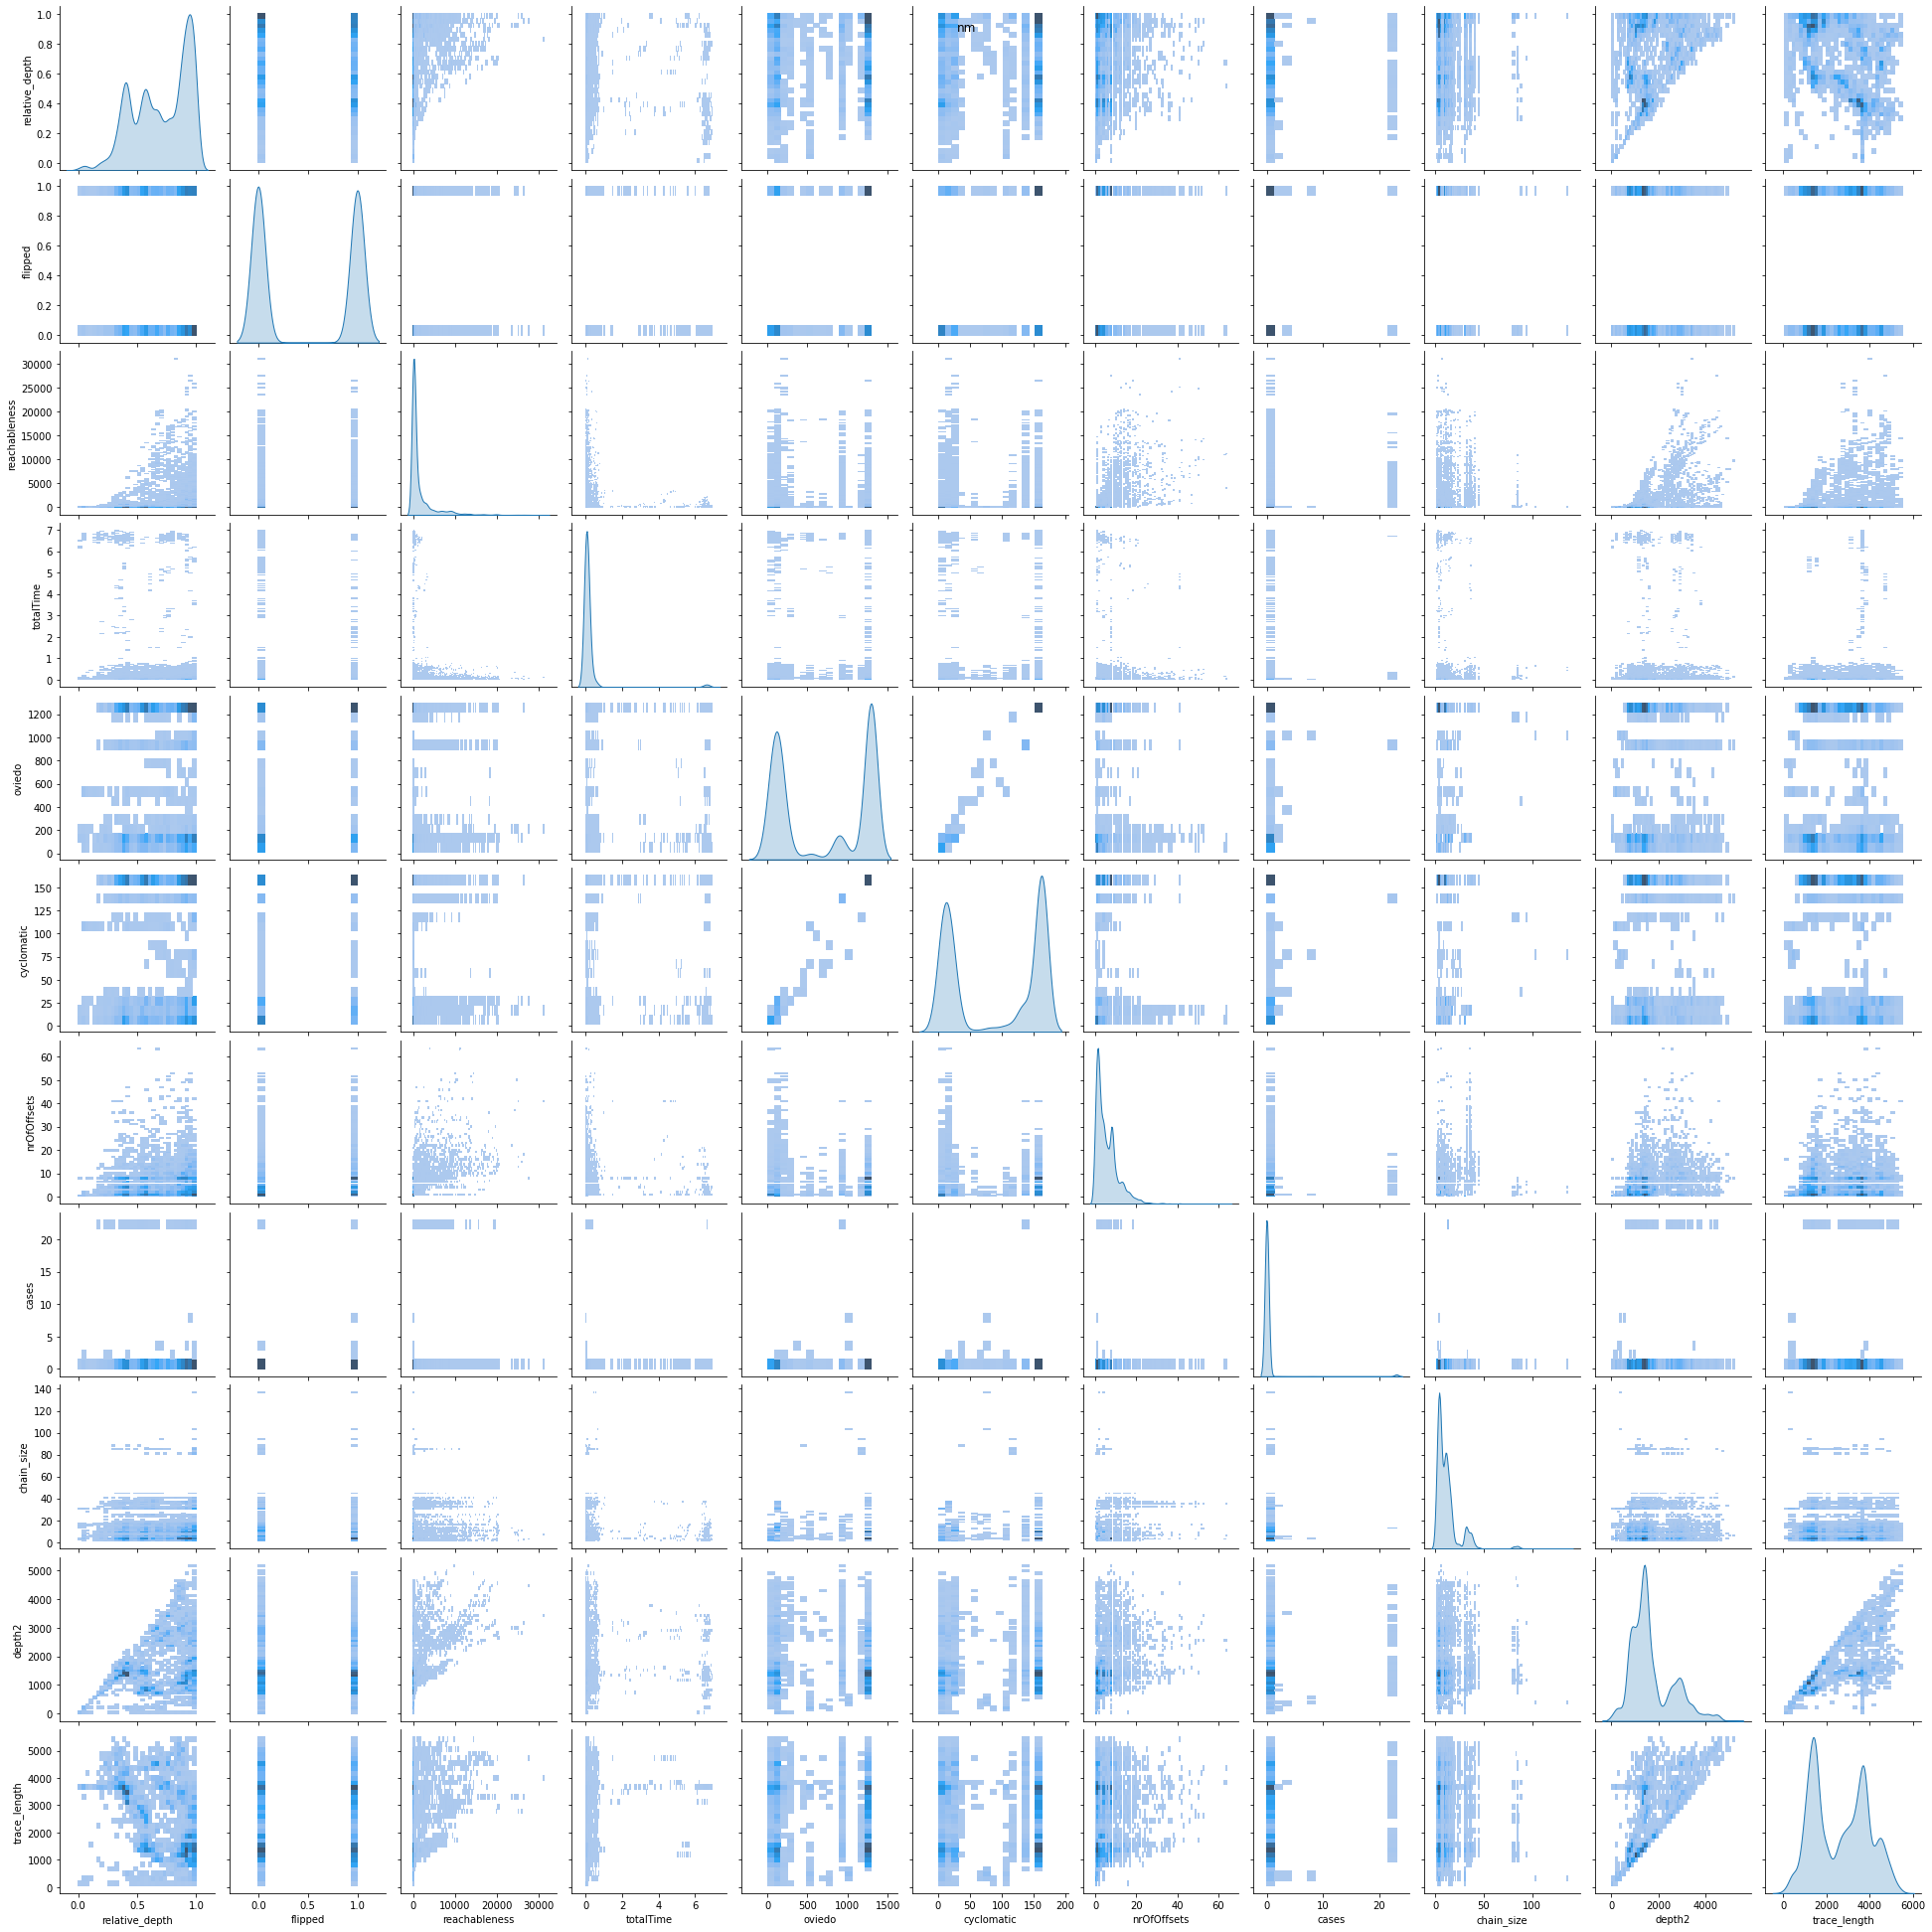

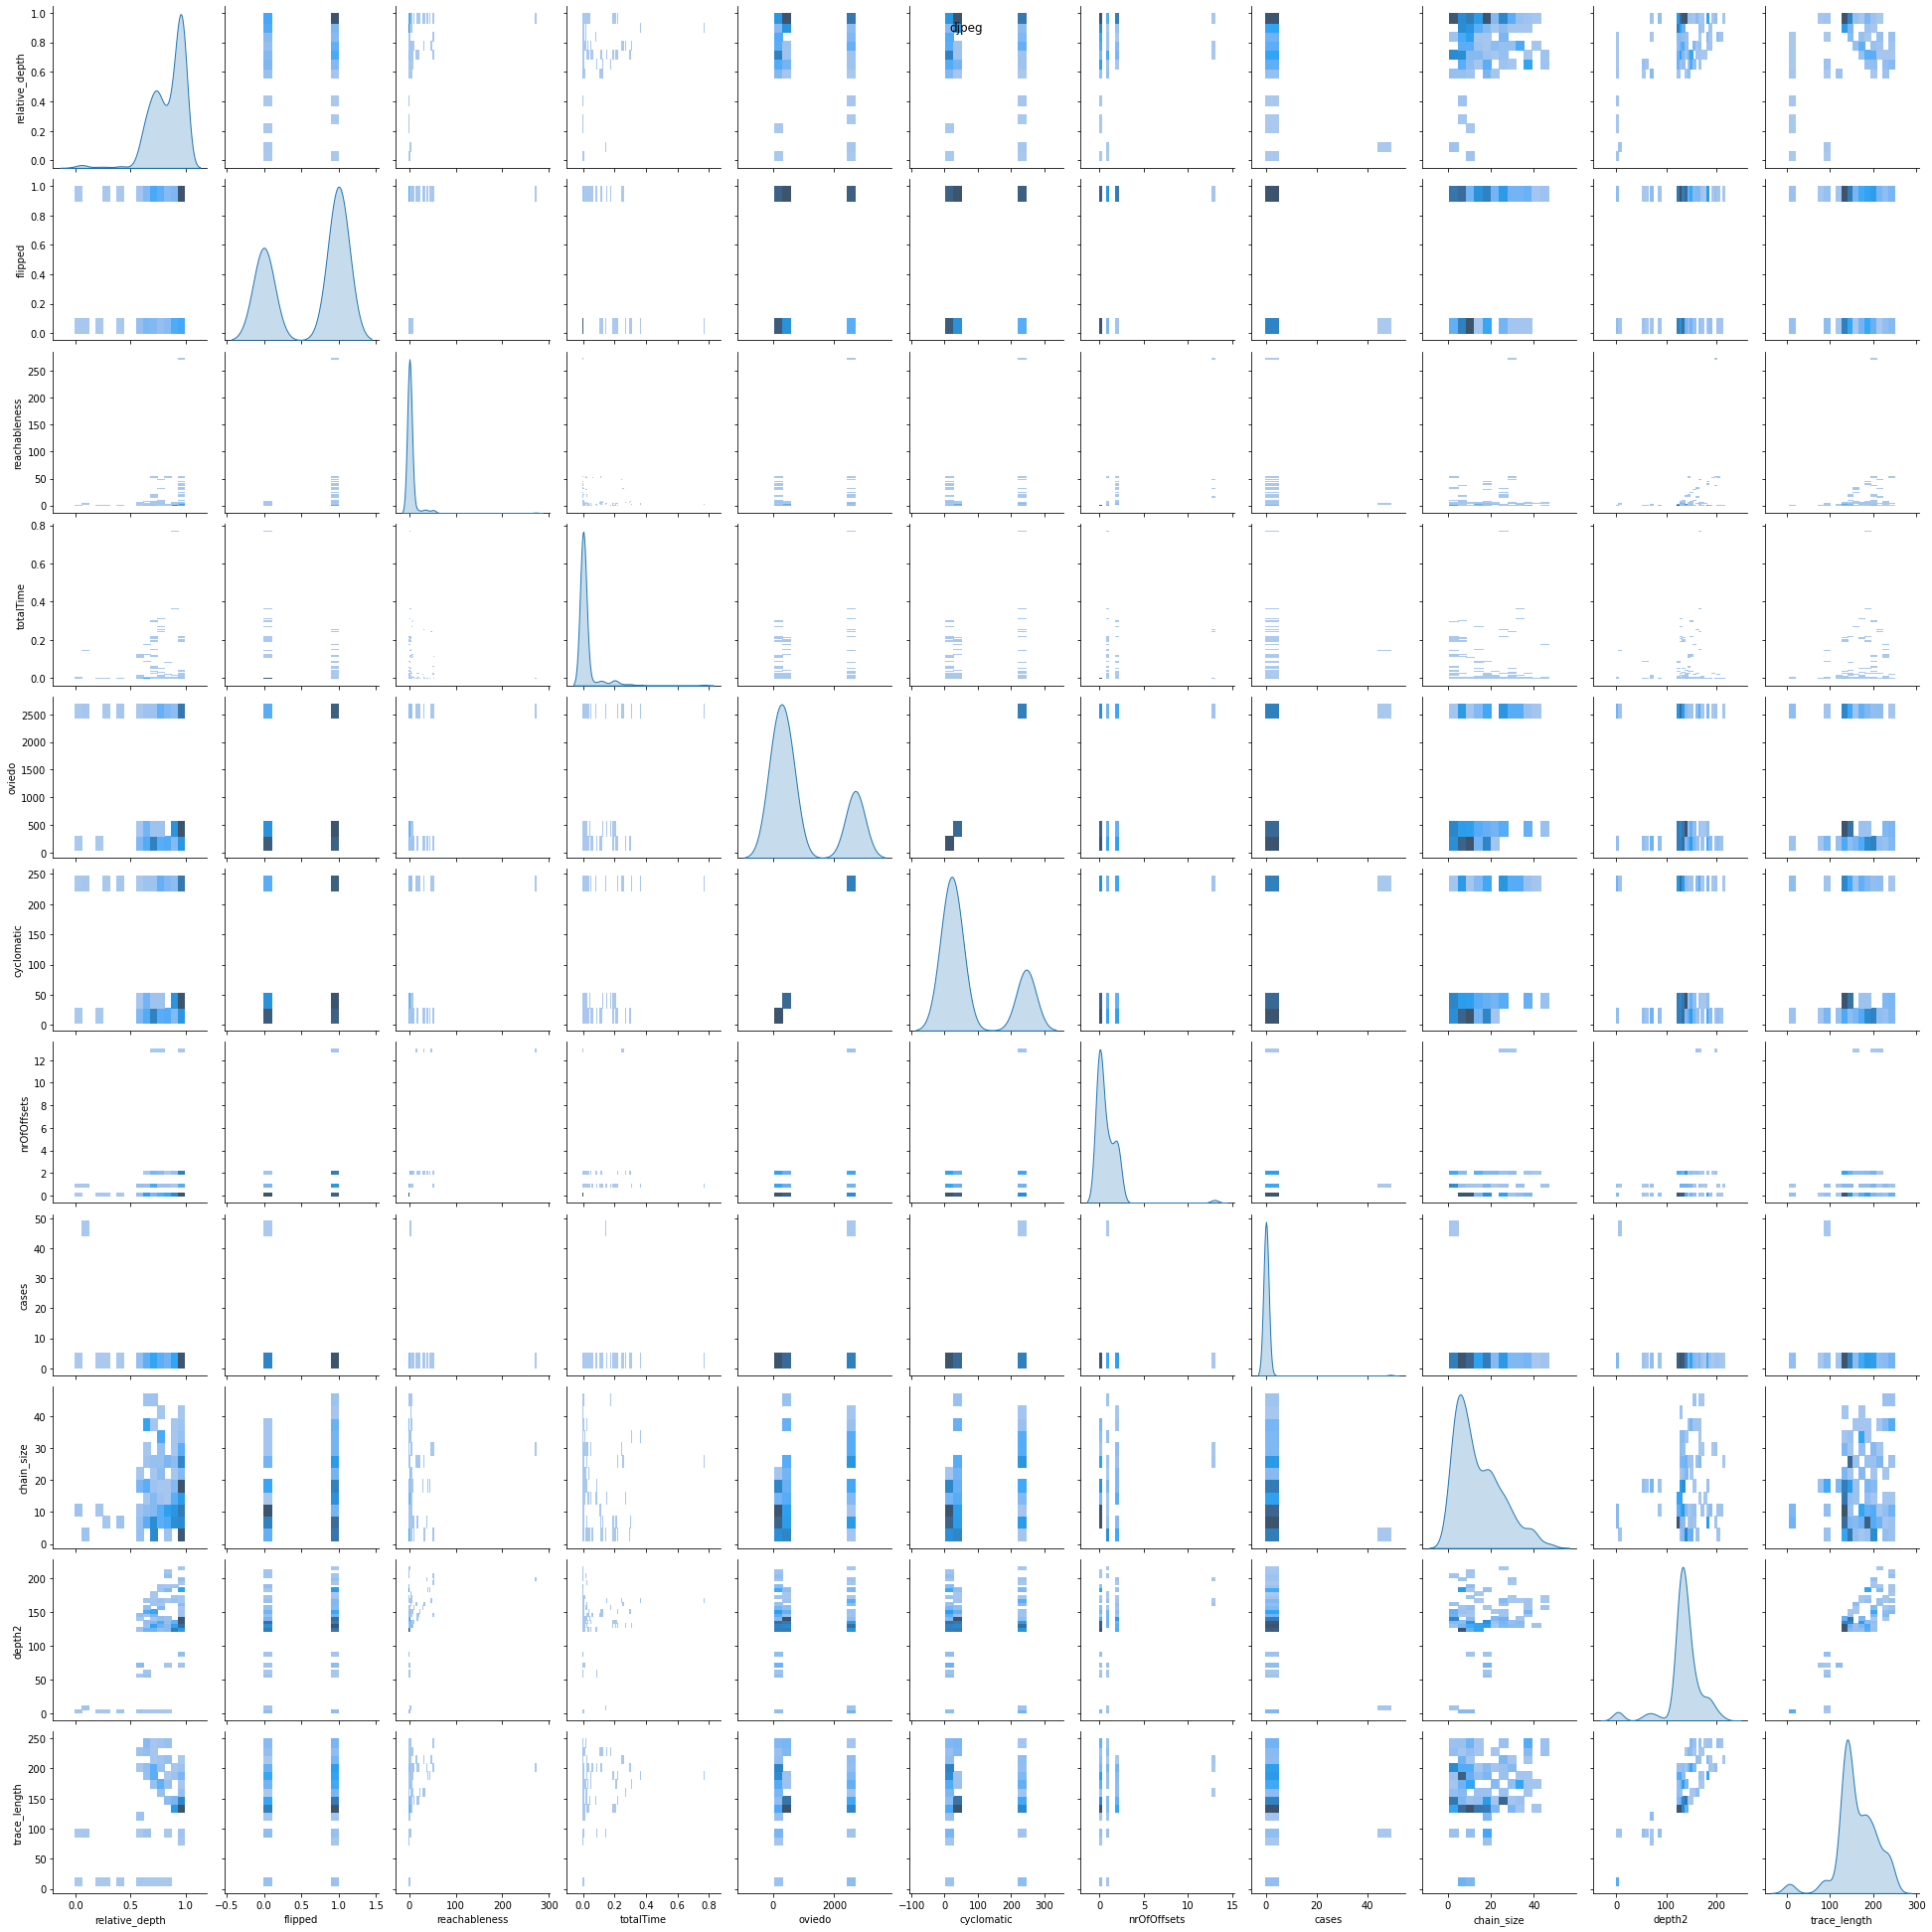

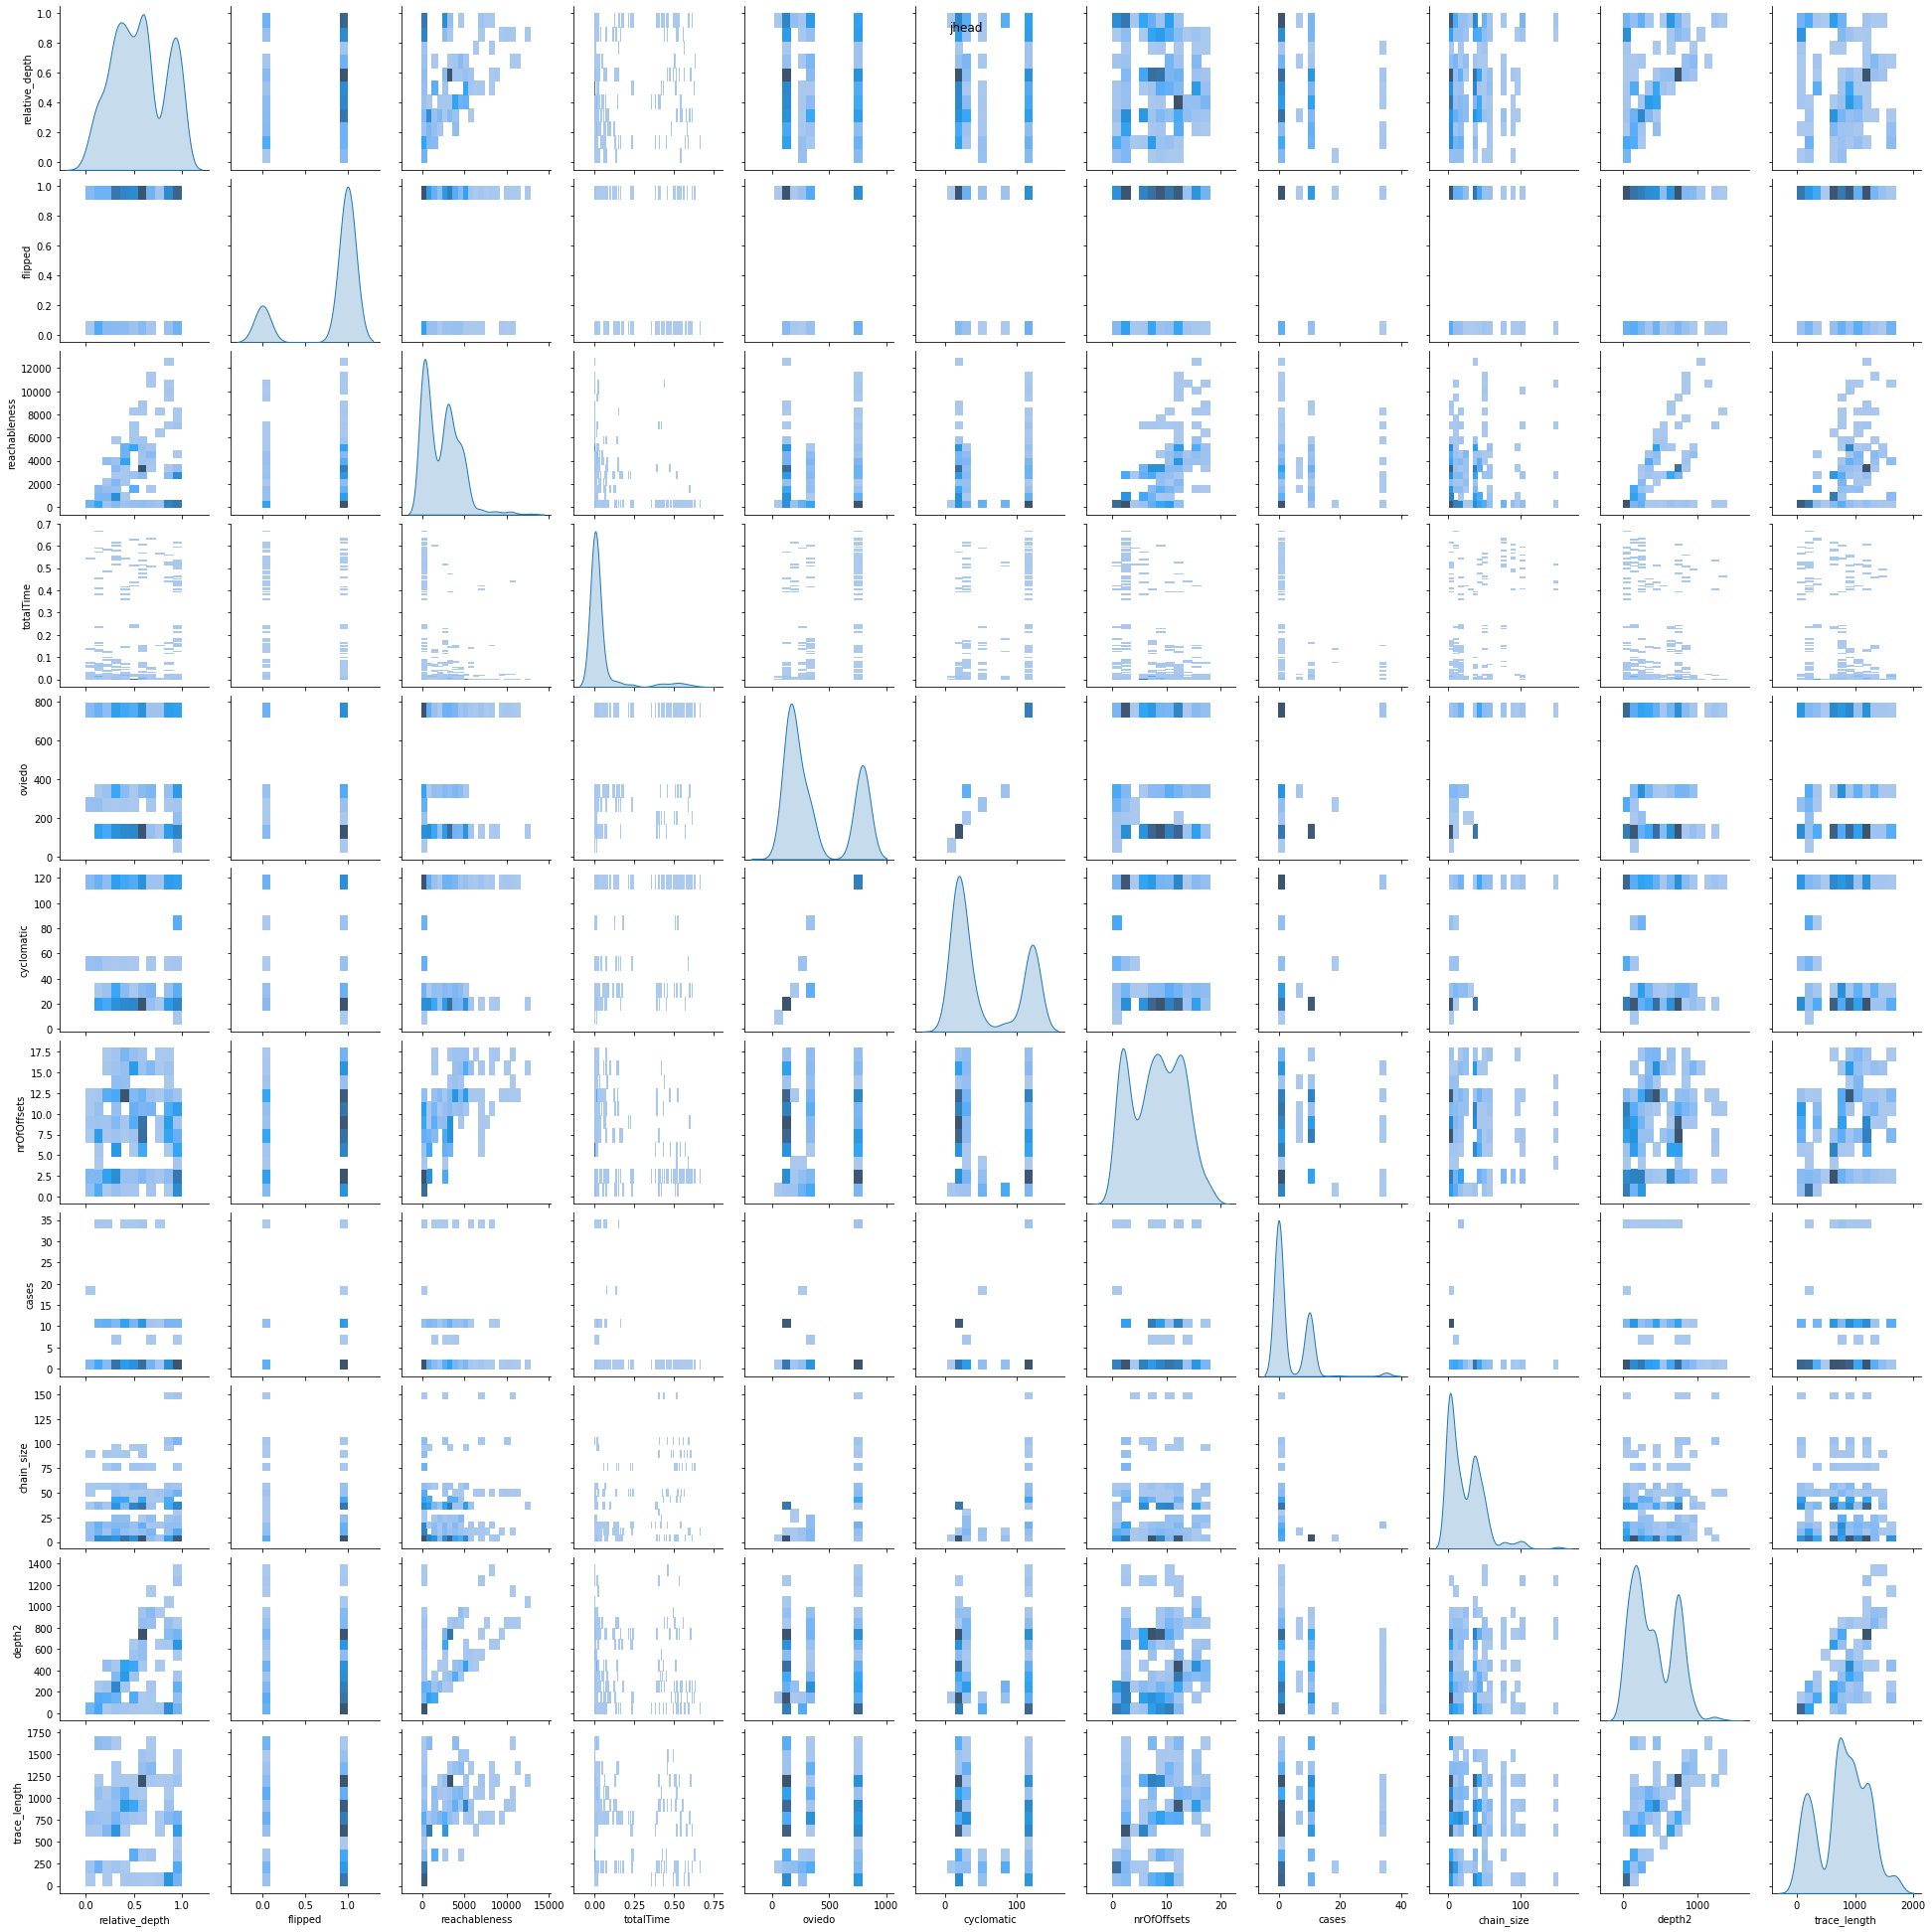

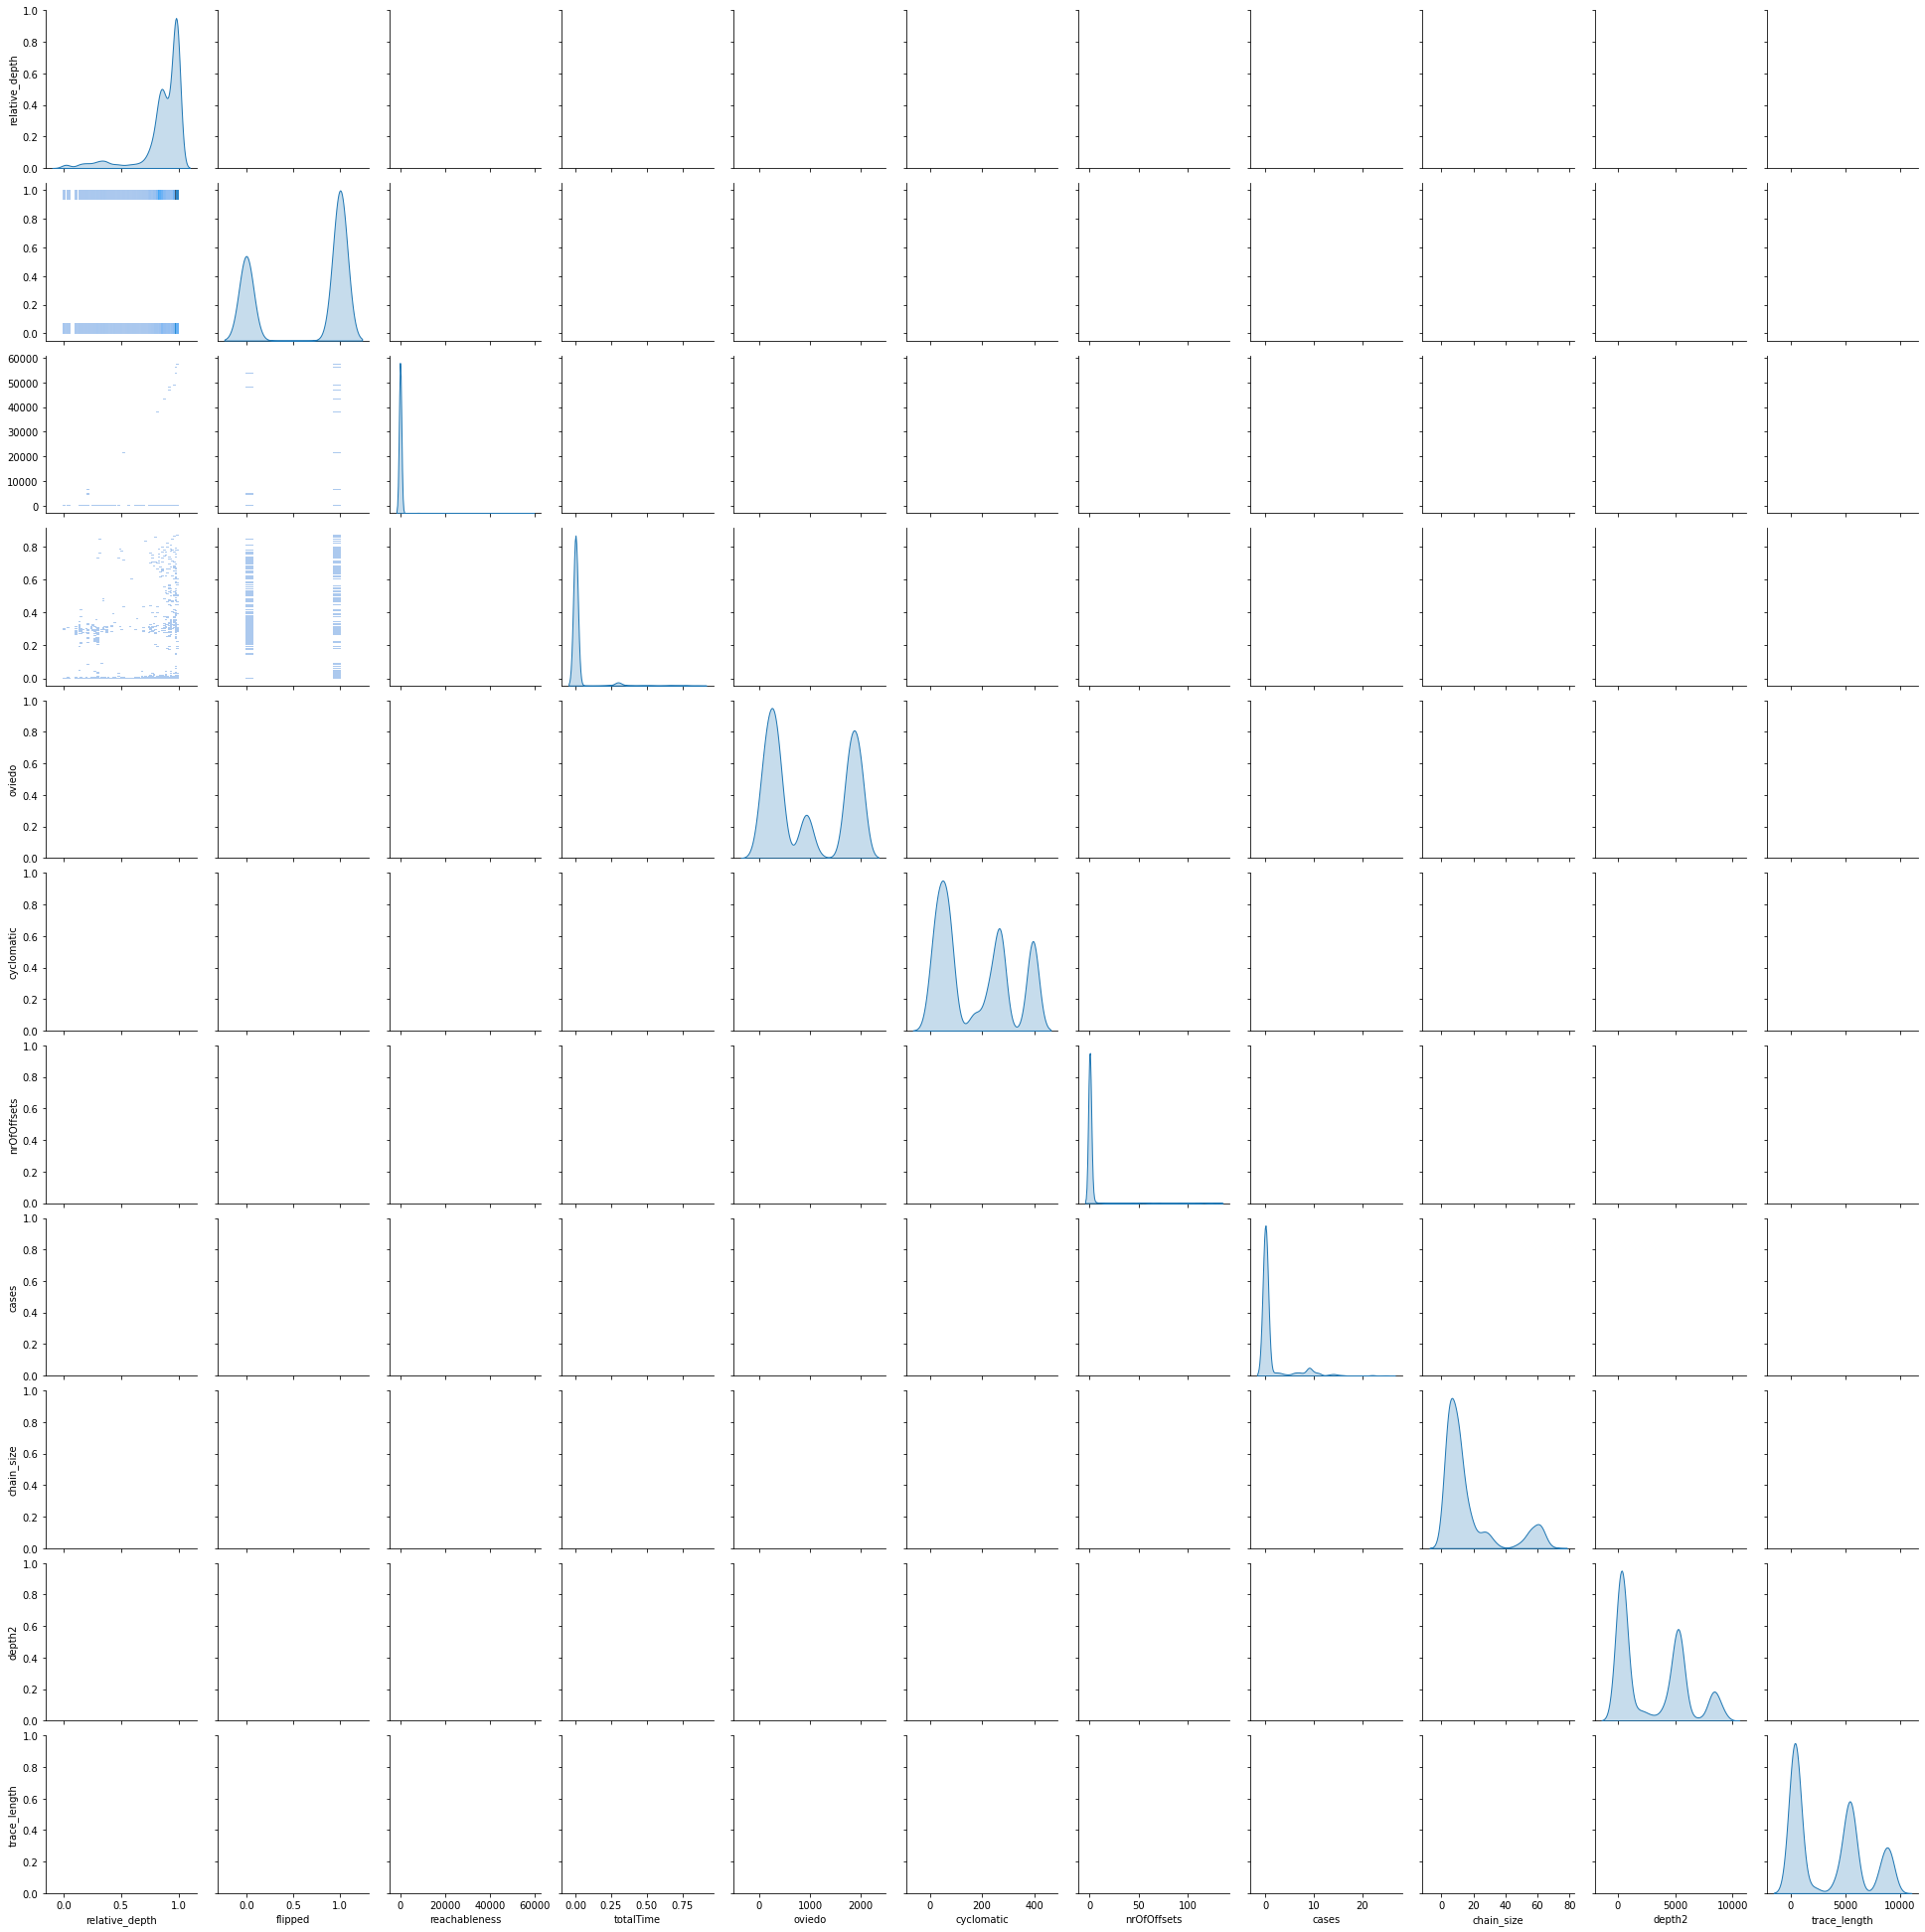

In [20]:

for program in programs:
    g = sns.pairplot(df_grouped[df_grouped.program == program], vars=var_names, kind="hist", diag_kind="kde")
    g.fig.suptitle(program)

### Correlation
We will calculate the correlation coefficients to see colinearity

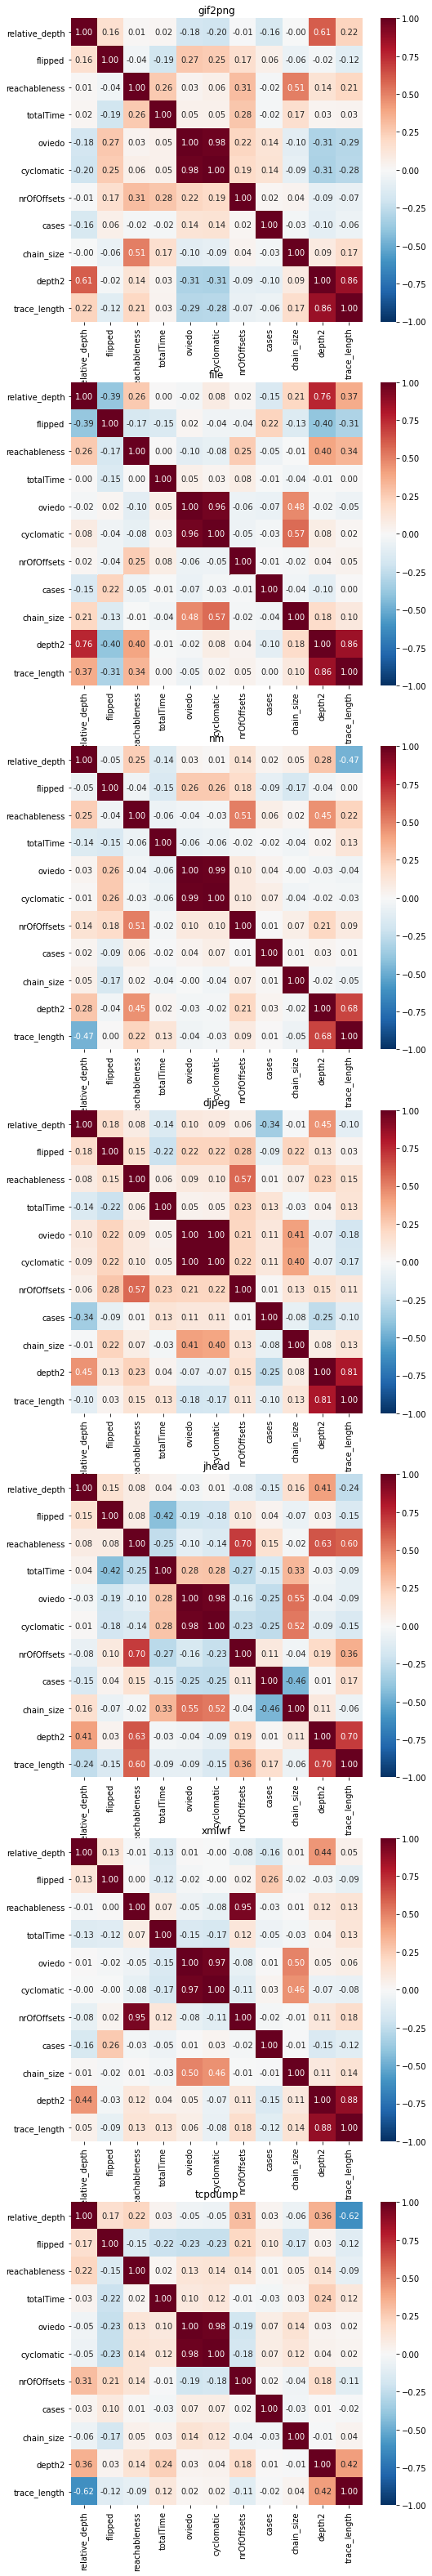

In [8]:
fig, axs = plt.subplots(nrows=programs.size, figsize=(8, programs.size * 8))
for ax, f in zip(axs, df_copy.program.unique()):
    ax.set_title(f)
    ax = sns.heatmap(df_grouped[df_grouped.program == f].corr(),
                    fmt=".2f", annot=True, ax=ax, cmap="RdBu_r", vmin=-1, vmax=1)
#fig.savefig("output.png", dpi=300)

We see a colinearity between the cyclomatic and oviedo variable.
Also between the depth2 and tracelength.

### Check histogram of all flipped conditions

Plotted gif2png relative_depth
Plotted gif2png totalTime
Plotted gif2png oviedo
Plotted gif2png cyclomatic
Plotted gif2png nrOfOffsets
Plotted gif2png cases
Plotted gif2png chain_size
Plotted gif2png depth2
Plotted gif2png trace_length
Plotted file relative_depth
Plotted file totalTime
Plotted file oviedo
Plotted file cyclomatic
Plotted file nrOfOffsets
Plotted file cases
Plotted file chain_size
Plotted file depth2
Plotted file trace_length
Plotted nm relative_depth
Plotted nm totalTime
Plotted nm oviedo
Plotted nm cyclomatic
Plotted nm nrOfOffsets
Plotted nm cases
Plotted nm chain_size
Plotted nm depth2
Plotted nm trace_length
Plotted djpeg relative_depth
Plotted djpeg totalTime
Plotted djpeg oviedo
Plotted djpeg cyclomatic
Plotted djpeg nrOfOffsets
Plotted djpeg cases
Plotted djpeg chain_size
Plotted djpeg depth2
Plotted djpeg trace_length
Plotted jhead relative_depth
Plotted jhead totalTime
Plotted jhead oviedo
Plotted jhead cyclomatic
Plotted jhead nrOfOffsets
Plotted jhead cases
P

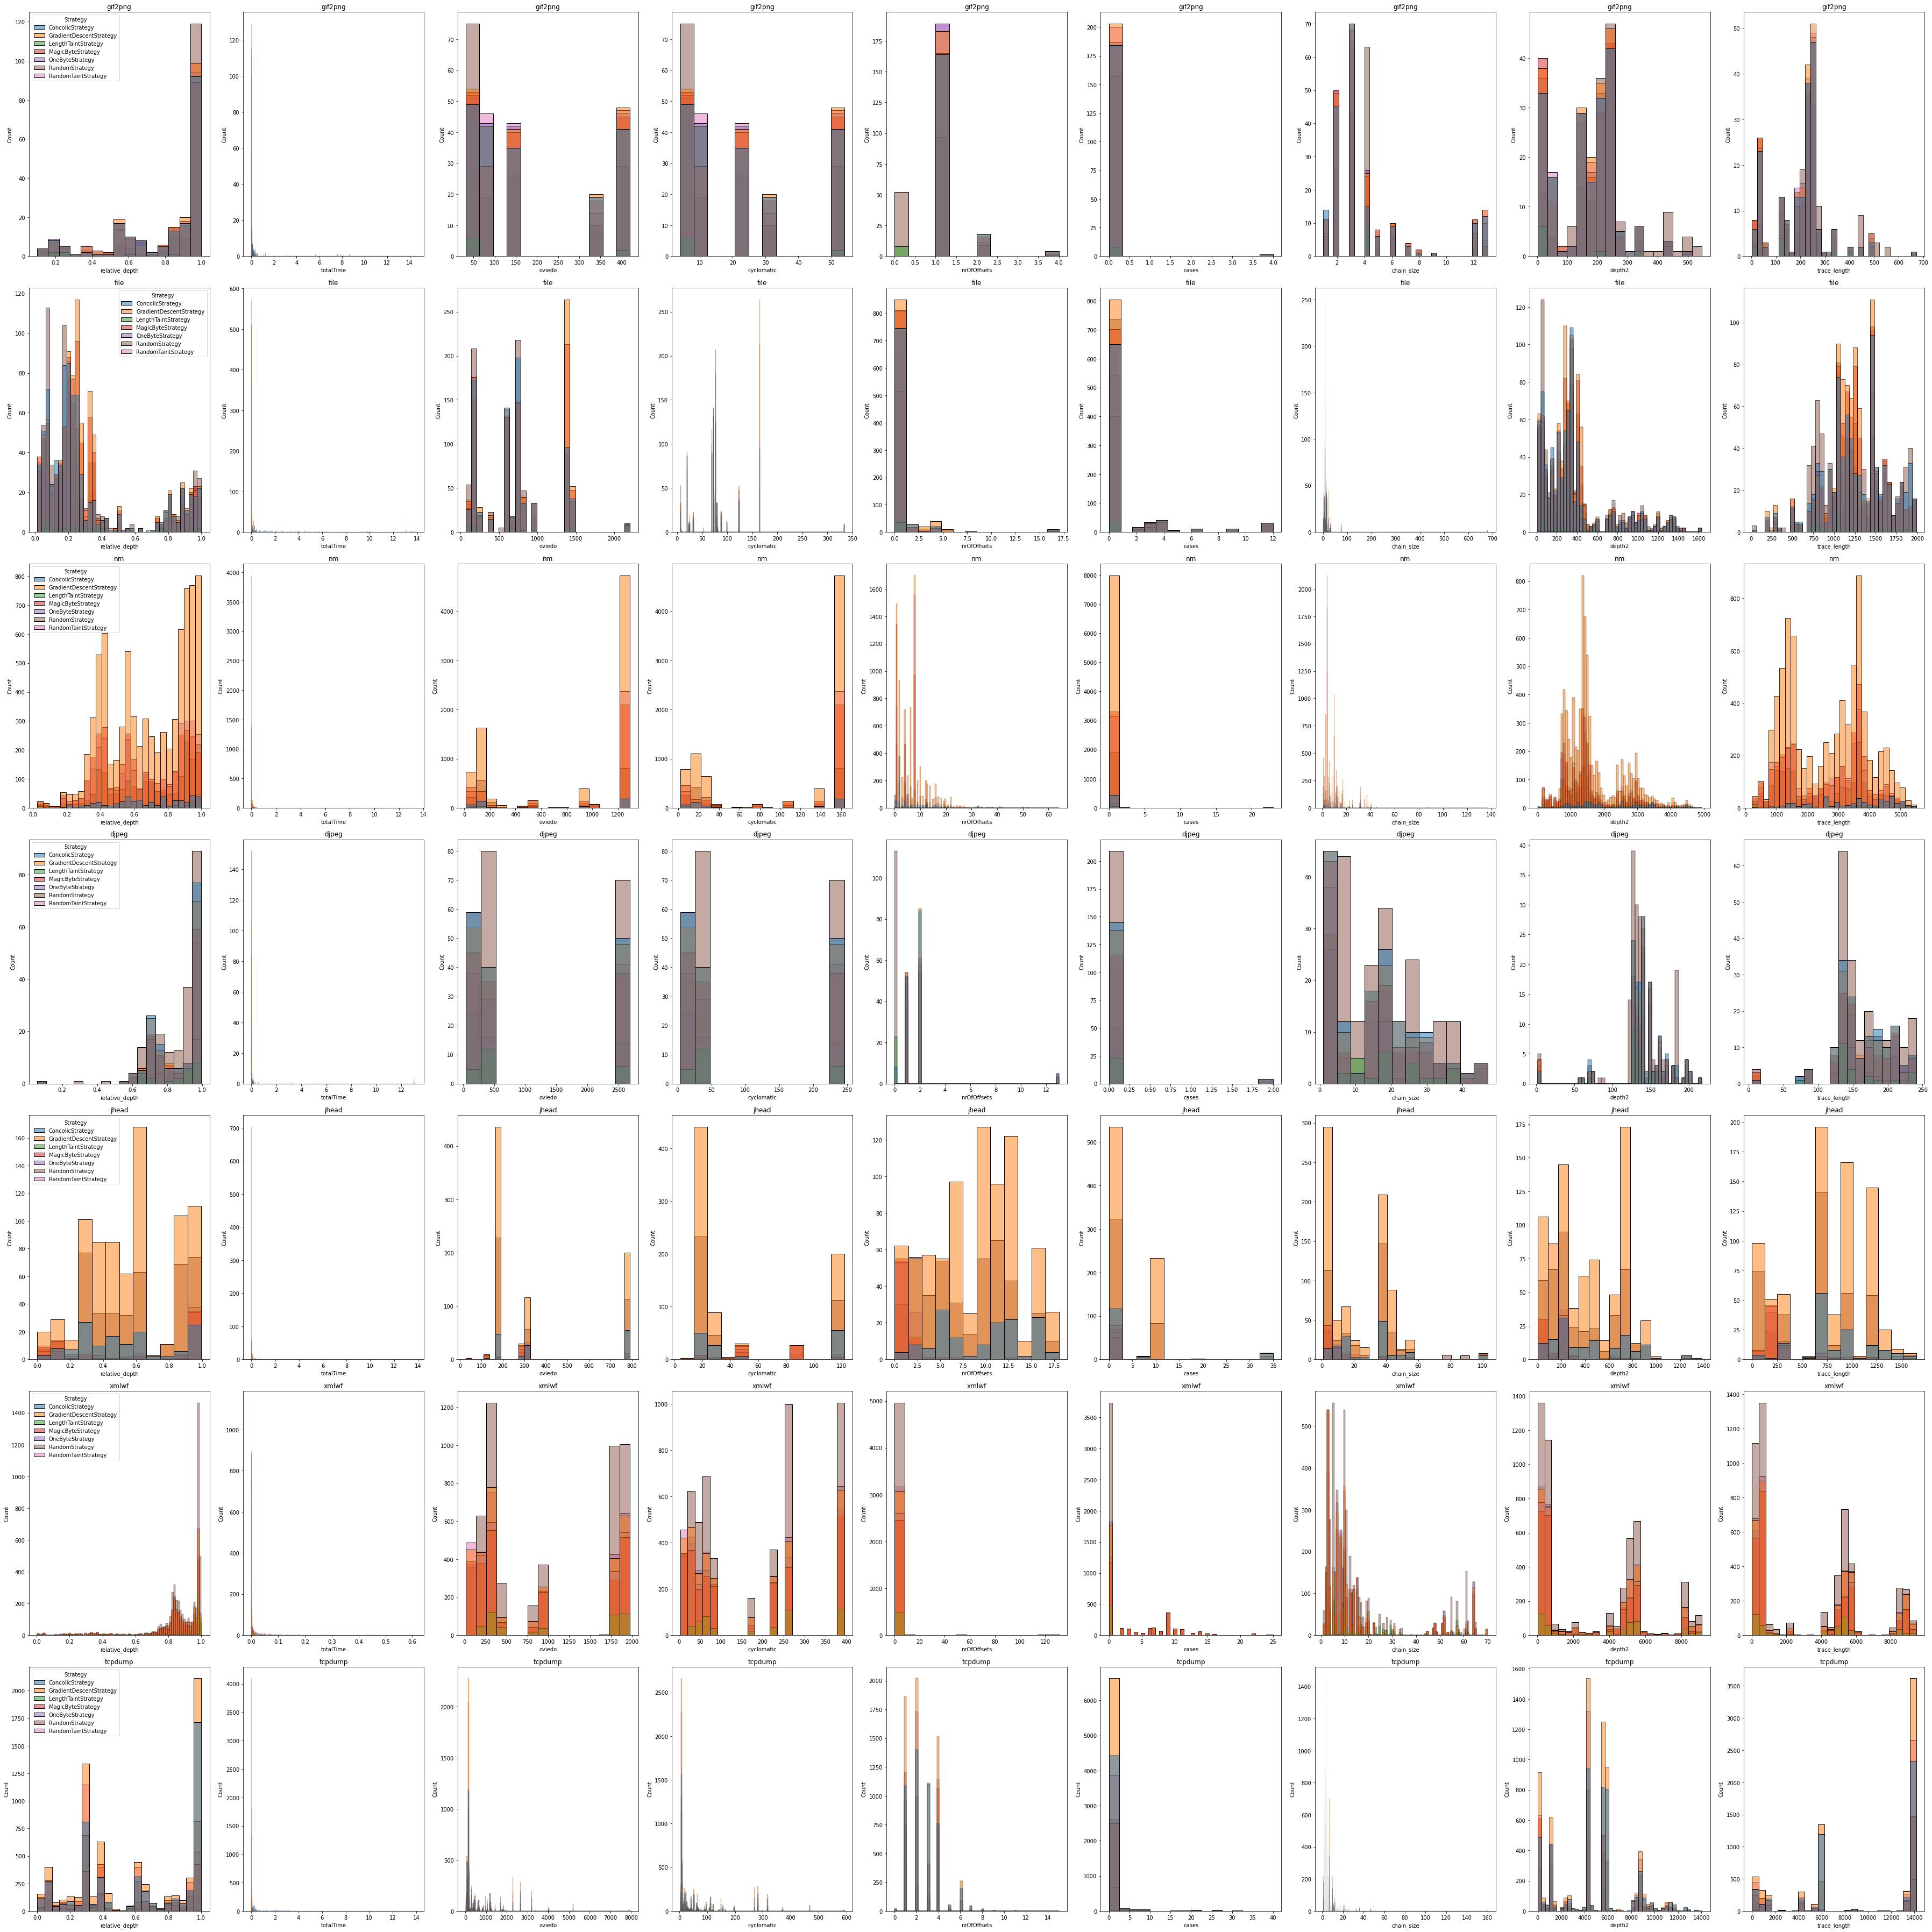

In [22]:
var_names_flipped = var_names.copy()
var_names_flipped.remove('flipped')
var_names_flipped.remove('reachableness')
fig, axs = plt.subplots(len(programs),len(var_names_flipped), figsize=(50,50))
#axs = axs.flatten()

for ax_program, program in zip(axs, programs):
    first = True
    for ax, var_name in zip(ax_program, var_names_flipped):
        program_data = df_copy[(df_copy.program == program) & (df_copy.flipped == 1)].copy()
        g = sns.histplot(data=program_data, x=var_name, hue="Strategy", ax=ax)
        ax.title.set_text(program)
        print("Plotted %s %s" % (program, var_name))
        if not first:
            ax.get_legend().remove()
        first = False
plt.tight_layout()

### Check timing distribution for flipped conditions

Plotted gif2png totalTime
Plotted gif2png totalTime
Plotted gif2png totalTime
Plotted gif2png totalTime
Plotted gif2png totalTime
Plotted gif2png totalTime
Plotted gif2png totalTime
Plotted file totalTime
Plotted file totalTime
Plotted file totalTime
Plotted file totalTime
Plotted file totalTime
Plotted file totalTime
Plotted file totalTime
Plotted nm totalTime
Plotted nm totalTime
Plotted nm totalTime
Plotted nm totalTime
Plotted nm totalTime
Plotted nm totalTime
Plotted nm totalTime
Plotted djpeg totalTime
Plotted djpeg totalTime
Plotted djpeg totalTime
Plotted djpeg totalTime
Plotted djpeg totalTime
Plotted djpeg totalTime
Plotted djpeg totalTime
Plotted jhead totalTime
Plotted jhead totalTime
Plotted jhead totalTime
Plotted jhead totalTime
Plotted jhead totalTime
Plotted jhead totalTime
Plotted jhead totalTime
Plotted xmlwf totalTime
Plotted xmlwf totalTime
Plotted xmlwf totalTime
Plotted xmlwf totalTime
Plotted xmlwf totalTime
Plotted xmlwf totalTime
Plotted xmlwf totalTime
Plotte

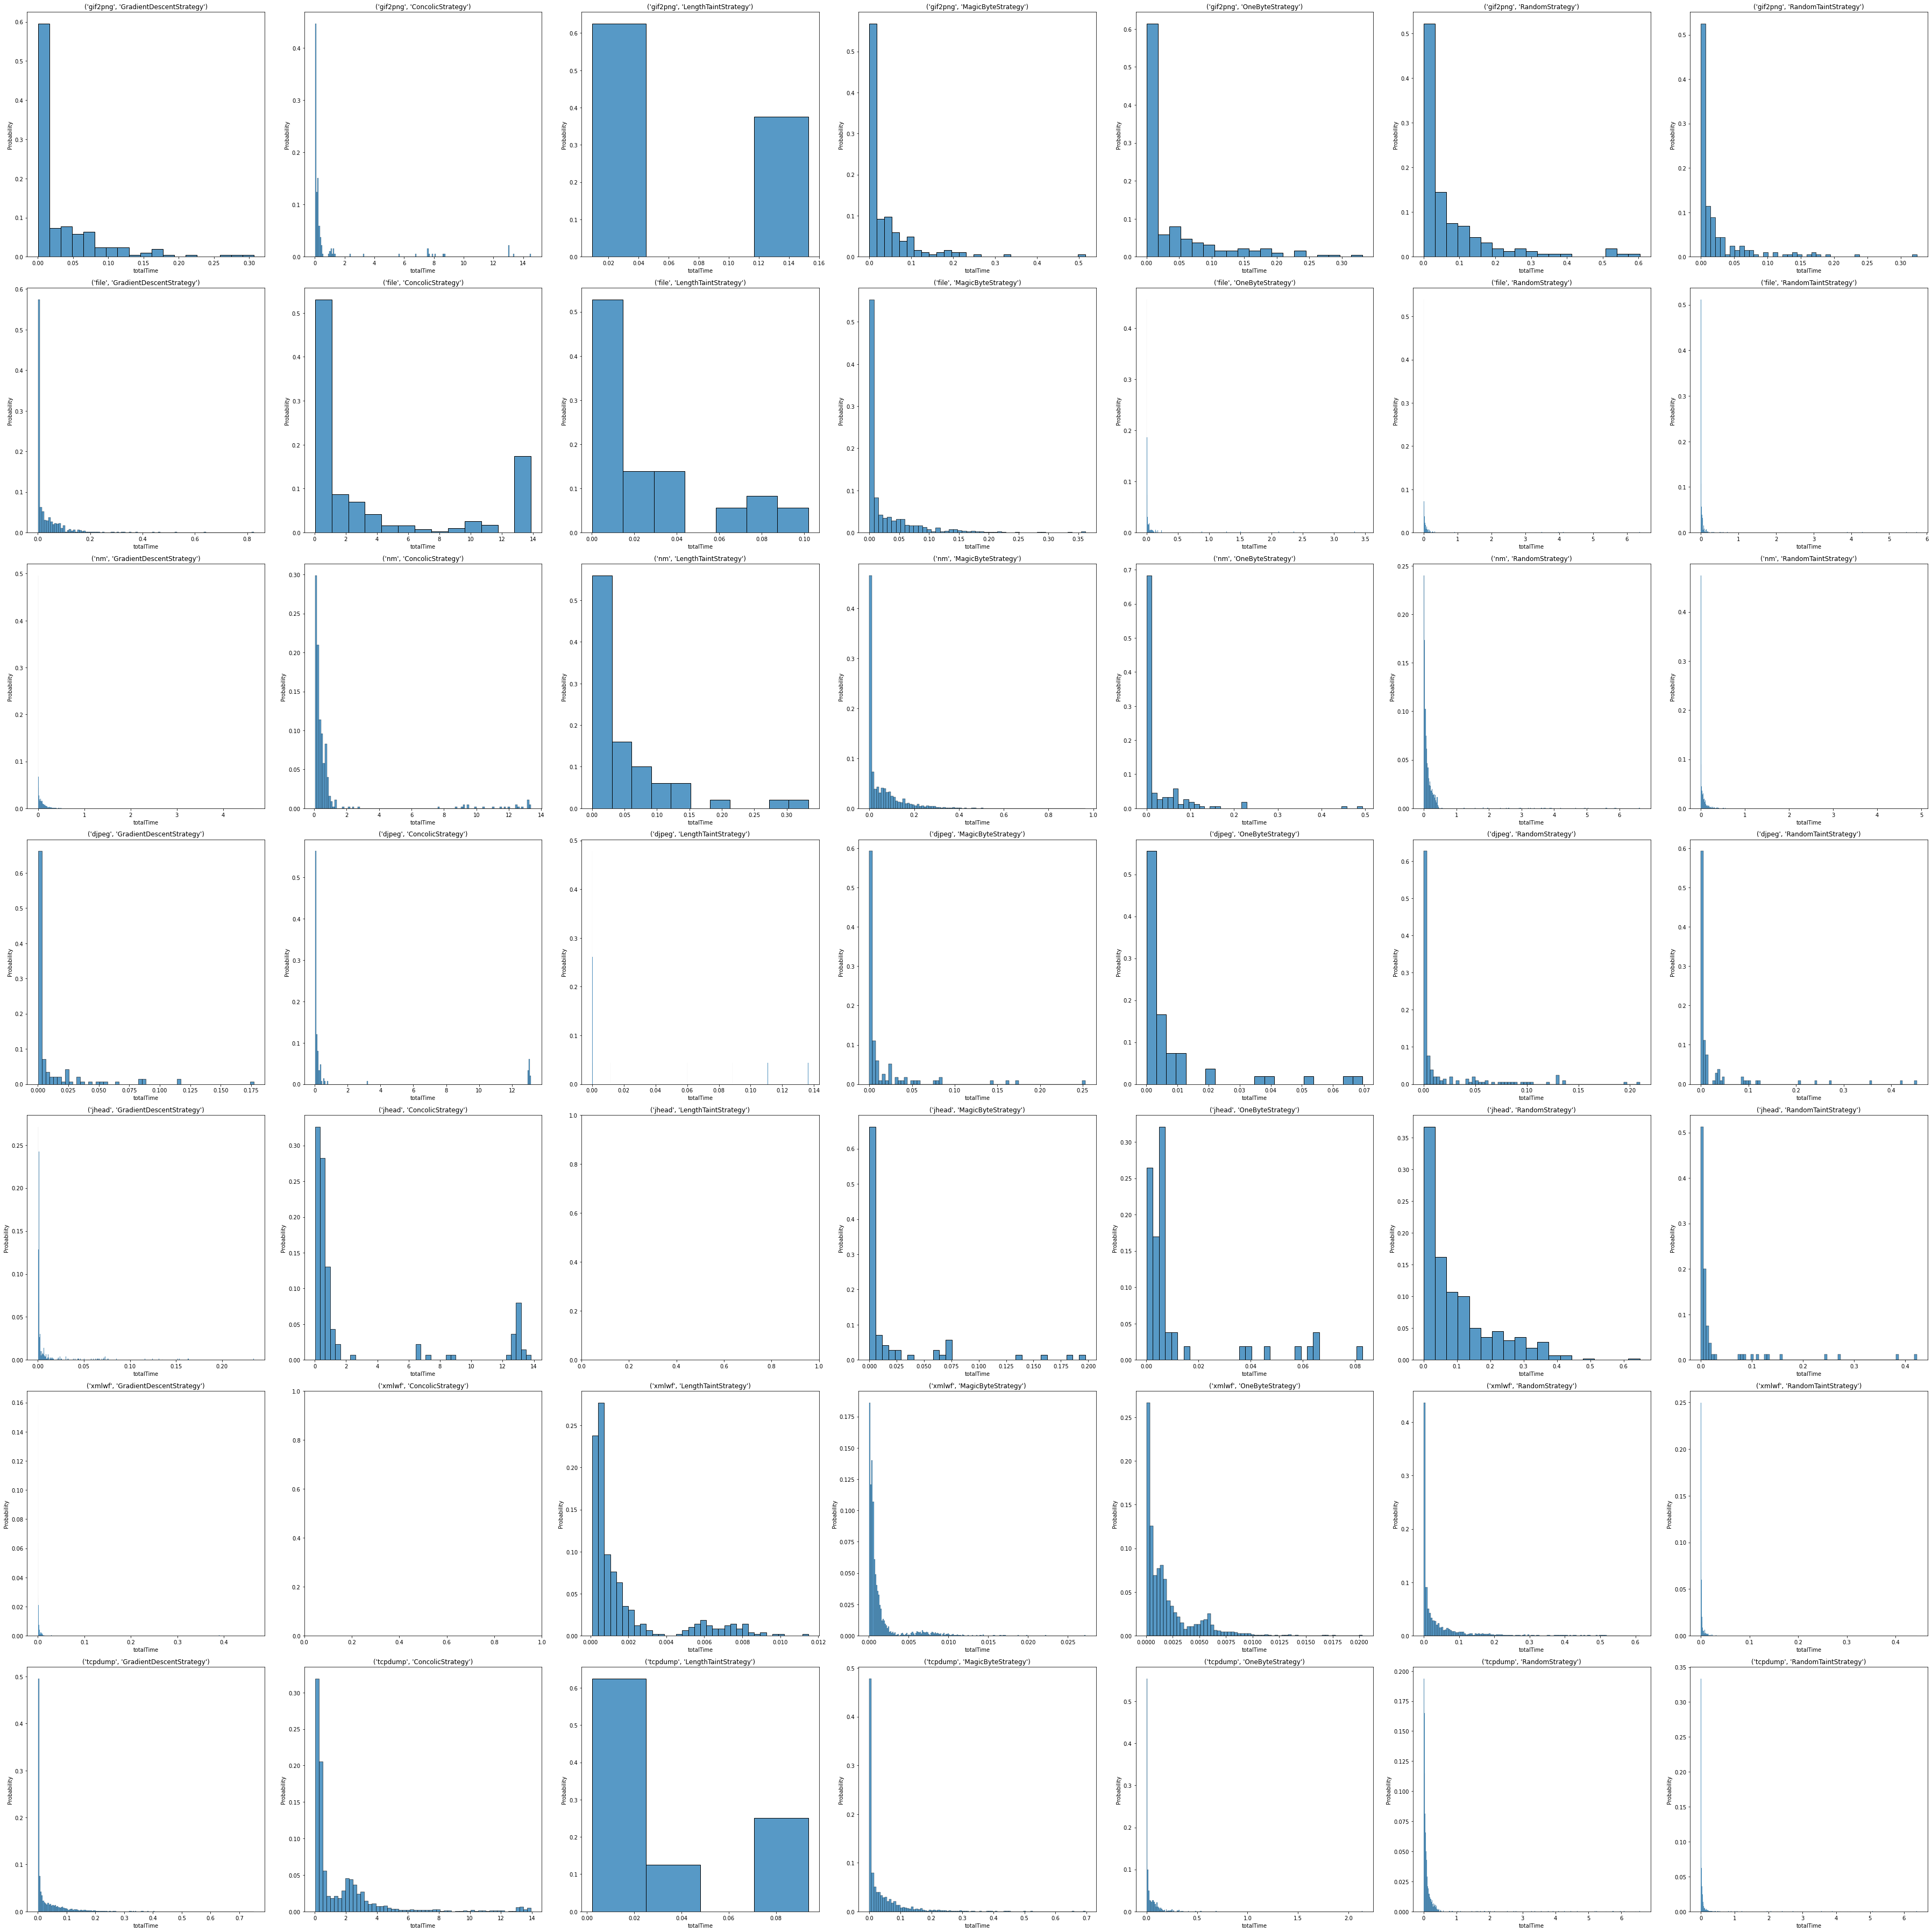

In [35]:
fig, axs = plt.subplots(len(programs),len(df_copy.Strategy.unique()), figsize=(50,50))
#axs = axs.flatten()
for ax_row, program in zip(axs, programs):
    for ax, strategy in zip(ax_row, df_copy.Strategy.unique()):
        program_data = df_copy[(df_copy.program == program) & (df_copy.flipped == 1) & (df_copy.Strategy == strategy)].copy()
        g = sns.histplot(data=program_data, x='totalTime', ax=ax, stat='probability')
        ax.title.set_text((program, strategy))
        print("Plotted %s %s" % (program, 'totalTime'))
plt.tight_layout()

### Create code to split in test and train set and cross validation

2 types of models:

- Classify flipped or not flipped based on properties
- Create for every strategy a time estimation to pick the minimal.

Do this on program basis and agregation basis AND compare the program level models with the difficult critical region statistic.

The first step is grouping the data together when we start looking at the flips.

The exact same data on a condition is now available multiple times in the dataset but some times with 1 and sometimes with 0 based on the Strategy. We will put a 1 if any strategy flipped the condition, and a 0 otherwise.

Then we will do the feature selection.

In [7]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif

### Feature selection for classification

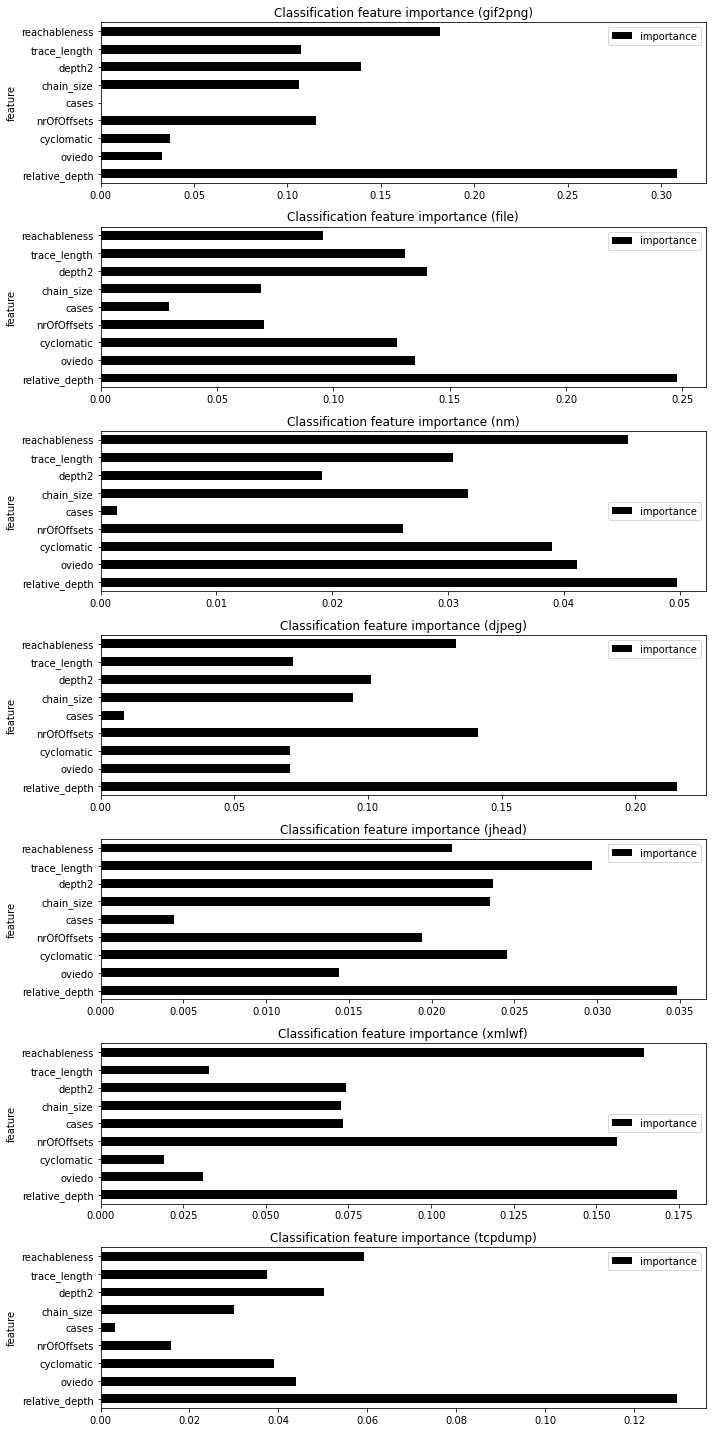

In [8]:
#construct all properties which can be flipped
all_features = ['relative_depth', 'oviedo', 'cyclomatic', 'nrOfOffsets', 'cases', 'chain_size', 'depth2', 'trace_length', 'reachableness']
fig, axs = plt.subplots(nrows=len(programs), figsize=(10, 20))
for ax, program in zip(axs, programs):
    mic = mutual_info_classif(df_copy.loc[df_copy.program == program, all_features], df_copy.loc[df_copy.program == program, "flipped"], random_state=0)
    ax.set_title(f"Classification feature importance ({program})")
    ax = pd.DataFrame({"feature": list(all_features), "importance": mic}) \
            .set_index("feature").plot.barh(ax=ax, color="k")
plt.tight_layout()

From the graphs it is clear that the relative depth is the most important feature, the depth2 is used in the computation for the relative depth by dividing the trace length, so do not use this feature due to collinearity.
The chainsize, ovideo and nrOfOffsets are the next canidates, we discard the cyclomatic and cases, since cases is always the lowest and cyclomatic has a high collinearity with oviedo. The tracelengh is also used in the relative_depth so we discard this variable as well.
We also use reachableness, since this is a combination between nrOfOffsets and depth.

In [9]:
selected_features = ['relative_depth', 'oviedo',  'nrOfOffsets', 'chain_size', 'reachableness']

### Mann-Whitney U test to see which features are significant.

In [ ]:
mann_whitney_test_result = {}
for program in programs:
    mann_whitney_test_result[program] = {}
    for feature in all_features:
        program_data = df_copy[df_copy["program"] == program].copy()
        continuity = (True if feature == 'relative_depth' else False)
        mann_whitney_test_result[program][feature] = scipy.stats.mannwhitneyu(program_data[program_data["flipped"] == 0][feature], program_data[program_data["flipped"] == 1][feature], use_continuity = continuity)
print(mann_whitney_test_result)        

### Create ML models for classification

In [10]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [11]:
TEST_MODELS = {
    "LinearSVC": (
        Pipeline(steps=[('scaler', RobustScaler()), ('model', LinearSVC(random_state=0, max_iter=400))]),
        {"model__C":       [1, 10, 100, 1000, 10000]},
        ("accuracy", "precision_macro", "f1_macro")
    ),
    "SVC": (
        Pipeline(steps=[('scaler', RobustScaler()), ('model', SVC(random_state=0))]),
        {
            "model__C":       [1, 10, 100, 1000, 10000],
            "model__gamma":   [.001, .01, .1, "scale"]
        },
        ("accuracy", "precision_macro", "f1_macro")
    ),
    "NuSVC": (
        Pipeline(steps=[('scaler', RobustScaler()), ('model', NuSVC(random_state=0))]),
        {
            "model__gamma":   [.001, .01, .1, "scale"]
        },
        ("accuracy", "precision_macro", "f1_macro")
    ),
    "Gausian": (
        Pipeline(steps=[('scaler', RobustScaler()), ('model', GaussianProcessClassifier(random_state=0))]),
        {'model__multi_class': ['one_vs_rest']},
        ("accuracy", "precision_macro", "f1_macro")
    ),
    "DecisionTree": (
        Pipeline(steps=[('scaler', RobustScaler()), ('model', DecisionTreeClassifier (random_state=0))]),
        {
            "model__min_samples_leaf": [2**n for n in range(5)],
            "model__max_depth":       [None] + [2**n for n in range(8, 13)]
        },
        ("accuracy", "precision_macro", "f1_macro")
    ),
    "NeuralNet": (
        Pipeline(steps=[('scaler', RobustScaler()), ('model', MLPClassifier(random_state=0))]),
        {
            'model__learning_rate': ["constant", "invscaling", "adaptive"],
            'model__hidden_layer_sizes': [(100,), (20,20), (20,20,20)],
            'model__alpha': [10.0 ** -n for n in range(1,7)],
            'model__activation': ["logistic", "relu", "Tanh"]
        },
        ("accuracy", "precision_macro", "f1_macro")
    ),    
}

In [12]:
TEST_MODELS['LinearSVC'][0].get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'model', 'scaler__copy', 'scaler__quantile_range', 'scaler__with_centering', 'scaler__with_scaling', 'model__C', 'model__class_weight', 'model__dual', 'model__fit_intercept', 'model__intercept_scaling', 'model__loss', 'model__max_iter', 'model__multi_class', 'model__penalty', 'model__random_state', 'model__tol', 'model__verbose'])

In [13]:

def test_classifier(program, data, selected_features, feature_to_classify):
    trained_models = {}
    fitted_models = {}
    test_data = {}
    for model_name, (model, grid, scoring) in TEST_MODELS.items():
        program_data = data[data.program == program]
        X_train, X_test, y_train, y_test = train_test_split(
            program_data[selected_features], 
            program_data[feature_to_classify],
            test_size=0.7
        )
        print("Training model %s with %s samples" % (model_name, len(X_train)))
        trained_models[model_name] = GridSearchCV(model, scoring=scoring, param_grid=grid, refit=scoring[0], n_jobs = -1)
        try:
            fitted = fitted_models[model_name] = trained_models[model_name].fit(X_train, y_train)
        except:
            print("Failed to fit model %s" % (model_name))
            continue
        print("Program %s for model %s had best score %s" % (program, model_name, fitted.best_score_))
        print(fitted.best_params_)
        #print("Grid scores on development set:")
        #print(fitted.cv_results_)
        means = fitted.cv_results_['mean_test_accuracy']
        stds = fitted.cv_results_['std_test_accuracy']
        #for mean, std, params in zip(means, stds, fitted.cv_results_['params']):
        #    print("%0.3f (+/-%0.03f) for %r"
        #          % (mean, std * 2, params))
        #print()
        #print()
        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, fitted.predict(X_test)
        test_data[model_name] = (y_true, y_pred)
        print(classification_report(y_true, y_pred))
    return (fitted_models, test_data)

In [43]:
model_results = {}
for program in programs:
    model_results[program] = test_classifier(program, df_grouped, selected_features, "flipped")

Training model LinearSVC with 150 samples


/home/luc/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Program gif2png for model LinearSVC had best score 0.6933333333333334
{'model__C': 100}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.60      0.73      0.66       161
           1       0.72      0.59      0.65       189

    accuracy                           0.65       350
   macro avg       0.66      0.66      0.65       350
weighted avg       0.67      0.65      0.65       350

Training model SVC with 150 samples
Program gif2png for model SVC had best score 0.7133333333333334
{'model__C': 100, 'model__gamma': 0.1}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.63      0.73      0.68       159
           1       0.74      0.64      0.69       191

    accura

/home/luc/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Program gif2png for model NeuralNet had best score 0.7266666666666667
{'model__activation': 'relu', 'model__alpha': 1e-06, 'model__hidden_layer_sizes': (20, 20, 20), 'model__learning_rate': 'constant'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.66      0.65      0.65       152
           1       0.73      0.74      0.74       198

    accuracy                           0.70       350
   macro avg       0.69      0.69      0.69       350
weighted avg       0.70      0.70      0.70       350

Training model LinearSVC with 1186 samples
Program file for model LinearSVC had best score 0.7639116406056093
{'model__C': 1}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0      

/home/luc/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Program file for model NeuralNet had best score 0.8187214126156791
{'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (20, 20, 20), 'model__learning_rate': 'constant'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1813
           1       0.76      0.69      0.73       957

    accuracy                           0.82      2770
   macro avg       0.80      0.79      0.80      2770
weighted avg       0.82      0.82      0.82      2770

Training model LinearSVC with 5133 samples


/home/luc/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Program nm for model LinearSVC had best score 0.6738749665465189
{'model__C': 1}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.68      0.71      0.69      6085
           1       0.69      0.66      0.67      5895

    accuracy                           0.68     11980
   macro avg       0.68      0.68      0.68     11980
weighted avg       0.68      0.68      0.68     11980

Training model SVC with 5133 samples
Program nm for model SVC had best score 0.7619309823840137
{'model__C': 10000, 'model__gamma': 'scale'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.77      0.78      0.77      6074
           1       0.77      0.76      0.76      5906

    accuracy   

/home/luc/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Program nm for model NeuralNet had best score 0.7858967715729873
{'model__activation': 'relu', 'model__alpha': 0.01, 'model__hidden_layer_sizes': (20, 20, 20), 'model__learning_rate': 'constant'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      6043
           1       0.81      0.80      0.80      5937

    accuracy                           0.81     11980
   macro avg       0.81      0.81      0.81     11980
weighted avg       0.81      0.81      0.81     11980

Training model LinearSVC with 124 samples


/home/luc/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Program djpeg for model LinearSVC had best score 0.749
{'model__C': 1}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.73      0.54      0.62       114
           1       0.74      0.87      0.80       177

    accuracy                           0.74       291
   macro avg       0.74      0.70      0.71       291
weighted avg       0.74      0.74      0.73       291

Training model SVC with 124 samples
Program djpeg for model SVC had best score 0.7346666666666668
{'model__C': 100, 'model__gamma': 0.001}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.52      0.70      0.60       108
           1       0.78      0.62      0.69       183

    accuracy               

/home/luc/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Program djpeg for model NeuralNet had best score 0.7336666666666667
{'model__activation': 'relu', 'model__alpha': 0.1, 'model__hidden_layer_sizes': (20, 20, 20), 'model__learning_rate': 'constant'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.56      0.77      0.65       108
           1       0.83      0.64      0.72       183

    accuracy                           0.69       291
   macro avg       0.69      0.71      0.69       291
weighted avg       0.73      0.69      0.70       291

Training model LinearSVC with 305 samples
Program jhead for model LinearSVC had best score 0.8098360655737705
{'model__C': 10}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.

/home/luc/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Program jhead for model NeuralNet had best score 0.8327868852459016
{'model__activation': 'relu', 'model__alpha': 1e-06, 'model__hidden_layer_sizes': (20, 20, 20), 'model__learning_rate': 'constant'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.54      0.45      0.49       136
           1       0.87      0.91      0.89       576

    accuracy                           0.82       712
   macro avg       0.71      0.68      0.69       712
weighted avg       0.81      0.82      0.82       712

Training model LinearSVC with 2694 samples


/home/luc/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Program xmlwf for model LinearSVC had best score 0.7100992475395025
{'model__C': 1}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.56      0.64      0.60      2276
           1       0.78      0.72      0.75      4010

    accuracy                           0.69      6286
   macro avg       0.67      0.68      0.67      6286
weighted avg       0.70      0.69      0.69      6286

Training model SVC with 2694 samples
Program xmlwf for model SVC had best score 0.7453531598513011
{'model__C': 10000, 'model__gamma': 0.1}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.66      0.57      0.62      2251
           1       0.78      0.84      0.81      4035

    accuracy 

/home/luc/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Program tcpdump for model LinearSVC had best score 0.7049180327868853
{'model__C': 1}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.71      0.51      0.59      3806
           1       0.71      0.85      0.78      5448

    accuracy                           0.71      9254
   macro avg       0.71      0.68      0.69      9254
weighted avg       0.71      0.71      0.70      9254

Training model SVC with 3965 samples
Program tcpdump for model SVC had best score 0.7906683480453973
{'model__C': 10000, 'model__gamma': 'scale'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.78      0.72      0.75      3783
           1       0.81      0.86      0.83      5471

    a

/home/luc/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [57]:
#for model in TEST_MODELS.keys():
#    for program in programs:
#        if model not in model_results[program][0]:
#            print("Model %s in program %s was skipped:" % (model, program))
#            continue
#        print("Model %s in program %s has best parameters:" % (model, program))          
#        print(model_results[program][0][model].best_params_)
for program in programs:
    best_precision = (0,'')
    best_recall = (0,'')
    best_f1 = (0,'')
    for model in TEST_MODELS.keys():
        if model not in model_results[program][0]:
            #print("Model %s in program %s was skipped:" % (model, program))
            continue
        #print("Model %s in program %s has best parameters:" % (model, program))          
        #print(model_results[program][0][model].best_params_)
        y_true, y_pred = model_results[program][1][model]
        report = classification_report(y_true, y_pred, output_dict=True)
        if best_precision[0] < report['weighted avg']['precision']:
            best_precision = (report['weighted avg']['precision'], model)
        if best_recall[0] < report['weighted avg']['recall']:
            best_recall = (report['weighted avg']['recall'], model)
        if best_f1[0] < report['weighted avg']['f1-score']:
            best_f1 = (report['weighted avg']['f1-score'], model)
    print("Program %s has:\nbest precision for %s\nbest recall for %s\nbest f1-score for %s" % (program, best_precision[1], best_recall[1], best_f1[1]))

Program gif2png has:
best precision for DecisionTree
best recall for NuSVC
best f1-score for NuSVC
Program file has:
best precision for DecisionTree
best recall for DecisionTree
best f1-score for DecisionTree
Program nm has:
best precision for DecisionTree
best recall for DecisionTree
best f1-score for DecisionTree
Program djpeg has:
best precision for DecisionTree
best recall for DecisionTree
best f1-score for DecisionTree
Program jhead has:
best precision for DecisionTree
best recall for DecisionTree
best f1-score for DecisionTree
Program xmlwf has:
best precision for DecisionTree
best recall for DecisionTree
best f1-score for DecisionTree
Program tcpdump has:
best precision for SVC
best recall for SVC
best f1-score for SVC


The classifier which most often works best is the decisiontree classifier

### Create regressors, train models for every strategy and pick the one which takes the least amount of time.
Check if this corresponds with the real data.

There are 2 ways to do this:

- Create regressors for every program and every strategy, pick the one with the least amount of time estimated.
- Create classification by combining the data and selecting the strategy with the lowest time. (I go for this)

In the end we will do a critical distance analysis.

In [16]:
strategies = df_copy.Strategy.unique()
df_grouped_strategy = df_copy[df_copy["Strategy"] == strategies[0]].copy()
df_grouped_strategy = df_grouped_strategy.reset_index(drop=True)

for strategy in strategies:
    df_temp = df_copy[df_copy["Strategy"] == strategy].copy().reset_index(drop=True)
    df_grouped_strategy.Strategy = df_grouped_strategy.Strategy.where(
        ((df_grouped_strategy.totalTime < df_temp.totalTime) & (df_temp.flipped == 1) & (df_grouped_strategy.flipped == 1)) | 
        (df_temp.flipped == 0), other=strategy)
    df_grouped_strategy.flipped |= df_temp.flipped
#Only select flipped samples
df_grouped_strategy = df_grouped_strategy[df_grouped_strategy["flipped"] == 1]
print(df_grouped_strategy.Strategy.unique())

['RandomTaintStrategy', 'RandomStrategy', 'GradientDescentStrategy', 'OneByteStrategy', 'MagicByteStrategy', 'LengthTaintStrategy', 'ConcolicStrategy']
Categories (7, object): ['RandomTaintStrategy', 'RandomStrategy', 'GradientDescentStrategy', 'OneByteStrategy', 'MagicByteStrategy', 'LengthTaintStrategy', 'ConcolicStrategy']


In [17]:
strategy_model_results = {}
for program in programs:
    strategy_model_results[program] = test_classifier(program, df_grouped_strategy, selected_features, "Strategy")

Training model LinearSVC with 82 samples


/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Program gif2png for model LinearSVC had best score 0.5955882352941176
{'model__C': 1}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

GradientDescentStrategy       0.18      0.07      0.11        27
    LengthTaintStrategy       1.00      0.60      0.75         5
      MagicByteStrategy       0.00      0.00      0.00        11
        OneByteStrategy       0.00      0.00      0.00        23
         RandomStrategy       0.95      0.78      0.86        46
    RandomTaintStrategy       0.54      0.94      0.69        82

               accuracy                           0.61       194
              macro avg       0.45      0.40      0.40       194
           weighted avg       0.50      0.61      0.53       194

Training model SVC with 82 samples
Program gif2png for model SVC had best score 0.5985294117647059
{'model__C': 10, 'model__g

/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Program gif2png for model Gausian had best score 0.5352941176470589
{'model__multi_class': 'one_vs_rest'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

GradientDescentStrategy       0.24      0.15      0.19        26
    LengthTaintStrategy       0.75      0.60      0.67         5
      MagicByteStrategy       0.14      0.08      0.10        13
        OneByteStrategy       0.22      0.09      0.13        22
         RandomStrategy       0.70      0.85      0.77        41
    RandomTaintStrategy       0.57      0.70      0.63        87

               accuracy                           0.55       194
              macro avg       0.44      0.41      0.41       194
           weighted avg       0.49      0.55      0.51       194

Training model DecisionTree with 82 samples


/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Program gif2png for model DecisionTree had best score 0.4992647058823529
{'model__max_depth': None, 'model__min_samples_leaf': 8}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

GradientDescentStrategy       0.10      0.17      0.13        23
    LengthTaintStrategy       0.00      0.00      0.00         6
      MagicByteStrategy       0.00      0.00      0.00        15
        OneByteStrategy       0.00      0.00      0.00        19
         RandomStrategy       0.85      0.77      0.81        44
    RandomTaintStrategy       0.57      0.75      0.65        87

               accuracy                           0.53       194
              macro avg       0.25      0.28      0.26       194
           weighted avg       0.46      0.53      0.49       194

Training model NeuralNet with 82 samples


/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samp

Program gif2png for model NeuralNet had best score 0.5477941176470589
{'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (20, 20, 20), 'model__learning_rate': 'constant'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

GradientDescentStrategy       0.35      0.29      0.32        24
    LengthTaintStrategy       0.00      0.00      0.00         7
      MagicByteStrategy       0.00      0.00      0.00        10
        OneByteStrategy       0.20      0.17      0.18        18
         RandomStrategy       0.75      0.91      0.82        46
    RandomTaintStrategy       0.59      0.69      0.64        89

               accuracy                           0.58       194
              macro avg       0.32      0.34      0.33       194
           weighted avg       0.51      0.58      0.54       194

Training 

/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Program file for model Gausian had best score 0.503342366757001
{'model__multi_class': 'one_vs_rest'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

       ConcolicStrategy       0.09      0.01      0.02        70
GradientDescentStrategy       0.43      0.31      0.36       221
    LengthTaintStrategy       0.43      0.14      0.21        21
      MagicByteStrategy       0.33      0.27      0.30       131
        OneByteStrategy       0.50      0.03      0.06        34
         RandomStrategy       0.59      0.69      0.64       210
    RandomTaintStrategy       0.46      0.72      0.56       265

               accuracy                           0.47       952
              macro avg       0.40      0.31      0.31       952
           weighted avg       0.44      0.47      0.43       952

Training model DecisionTree with 407 samples

/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least pop

Program file for model NeuralNet had best score 0.5208370972598615
{'model__activation': 'relu', 'model__alpha': 0.01, 'model__hidden_layer_sizes': (20, 20), 'model__learning_rate': 'constant'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

       ConcolicStrategy       0.00      0.00      0.00        64
GradientDescentStrategy       0.46      0.38      0.41       215
    LengthTaintStrategy       0.50      0.13      0.21        23
      MagicByteStrategy       0.34      0.39      0.36       121
        OneByteStrategy       0.00      0.00      0.00        36
         RandomStrategy       0.61      0.73      0.67       223
    RandomTaintStrategy       0.50      0.67      0.57       270

               accuracy                           0.50       952
              macro avg       0.34      0.33      0.32       952
           weighte

/home/luc/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Program nm for model LinearSVC had best score 0.6355029585798817
{'model__C': 1}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

       ConcolicStrategy       0.00      0.00      0.00        15
GradientDescentStrategy       0.64      1.00      0.78      3773
    LengthTaintStrategy       0.00      0.00      0.00        34
      MagicByteStrategy       0.00      0.00      0.00       693
        OneByteStrategy       0.00      0.00      0.00        23
         RandomStrategy       0.00      0.00      0.00       314
    RandomTaintStrategy       0.00      0.00      0.00      1065

               accuracy                           0.64      5917
              macro avg       0.09      0.14      0.11      5917
           weighted avg       0.41      0.64      0.50      5917

Training model SVC with 2535 samples
Program nm for model SVC had

/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

       ConcolicStrategy       0.67      0.25      0.36        16
GradientDescentStrategy       0.67      0.93      0.78      3781
    LengthTaintStrategy       0.83      0.16      0.26        32
      MagicByteStrategy       0.00      0.00      0.00       723
        OneByteStrategy       0.00      0.00      0.00        19
         RandomStrategy       0.20      0.01      0.01       297
    RandomTaintStrategy       0.50      0.31      0.38      1049

               accuracy                           0.65      5917
              macro avg       0.41      0.24      0.26      5917
           weighted avg       0.53      0.65      0.57      5917

Training model NuSVC with 2535 samples
Failed to fit model NuSVC
Training model Gausian with 2535 samples
Program nm for model Gausian had best score 0.6481262327416173
{'model__multi_class': 'one_vs_rest'}
Detailed classification report:

The model is trained on the full developme

/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Program nm for model DecisionTree had best score 0.6635108481262327
{'model__max_depth': None, 'model__min_samples_leaf': 16}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

       ConcolicStrategy       0.00      0.00      0.00        19
GradientDescentStrategy       0.74      0.83      0.78      3757
    LengthTaintStrategy       0.45      0.44      0.44        32
      MagicByteStrategy       0.37      0.38      0.38       726
        OneByteStrategy       0.00      0.00      0.00        17
         RandomStrategy       0.59      0.19      0.29       293
    RandomTaintStrategy       0.47      0.38      0.42      1073

               accuracy                           0.65      5917
              macro avg       0.38      0.32      0.33      5917
           weighted avg       0.64      0.65      0.64      5917

Training model Neura

/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least pop

Program nm for model NeuralNet had best score 0.6477317554240631
{'model__activation': 'relu', 'model__alpha': 0.1, 'model__hidden_layer_sizes': (20, 20, 20), 'model__learning_rate': 'constant'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

       ConcolicStrategy       0.25      0.12      0.17        16
GradientDescentStrategy       0.71      0.89      0.79      3770
    LengthTaintStrategy       0.29      0.12      0.17        32
      MagicByteStrategy       0.24      0.09      0.13       704
        OneByteStrategy       0.00      0.00      0.00        17
         RandomStrategy       0.50      0.00      0.01       307
    RandomTaintStrategy       0.49      0.43      0.46      1071

               accuracy                           0.66      5917
              macro avg       0.35      0.24      0.25      5917
           weight

/home/luc/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Program djpeg for model LinearSVC had best score 0.5583333333333333
{'model__C': 1}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

       ConcolicStrategy       0.00      0.00      0.00         3
GradientDescentStrategy       0.53      0.62      0.57        39
    LengthTaintStrategy       0.00      0.00      0.00        16
      MagicByteStrategy       0.00      0.00      0.00        13
        OneByteStrategy       0.00      0.00      0.00         8
         RandomStrategy       0.53      0.87      0.66        71
    RandomTaintStrategy       0.19      0.09      0.12        32

               accuracy                           0.49       182
              macro avg       0.18      0.23      0.19       182
           weighted avg       0.35      0.49      0.40       182

Training model SVC with 77 samples
Program djpeg for model SVC

/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Program djpeg for model Gausian had best score 0.41583333333333333
{'model__multi_class': 'one_vs_rest'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


                         precision    recall  f1-score   support

       ConcolicStrategy       0.00      0.00      0.00         4
GradientDescentStrategy       0.41      0.42      0.42        38
    LengthTaintStrategy       0.00      0.00      0.00        12
      MagicByteStrategy       0.00      0.00      0.00        15
        OneByteStrategy       0.00      0.00      0.00         6
         RandomStrategy       0.62      0.87      0.73        76
    RandomTaintStrategy       0.32      0.35      0.34        31

               accuracy                           0.51       182
              macro avg       0.19      0.23      0.21       182
           weighted avg       0.40      0.51      0.45       182

Training model DecisionTree with 77 samples
Program djpeg for model DecisionTree had best score 0.6383333333333333
{'model__max_depth': None, 'model__min_samples_leaf': 16}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on

/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samp

Program djpeg for model NeuralNet had best score 0.5349999999999999
{'model__activation': 'relu', 'model__alpha': 0.1, 'model__hidden_layer_sizes': (20, 20, 20), 'model__learning_rate': 'constant'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

       ConcolicStrategy       0.00      0.00      0.00         4
GradientDescentStrategy       0.42      0.55      0.48        38
    LengthTaintStrategy       0.22      0.15      0.18        13
      MagicByteStrategy       0.00      0.00      0.00        14
        OneByteStrategy       0.00      0.00      0.00         8
         RandomStrategy       0.57      0.77      0.66        75
    RandomTaintStrategy       0.23      0.17      0.19        30

               accuracy                           0.47       182
              macro avg       0.21      0.24      0.22       182
           wei

/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Program jhead for model Gausian had best score 0.8945306122448979
{'model__multi_class': 'one_vs_rest'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


                         precision    recall  f1-score   support

       ConcolicStrategy       0.00      0.00      0.00         2
GradientDescentStrategy       0.89      0.99      0.94       508
      MagicByteStrategy       0.00      0.00      0.00        15
        OneByteStrategy       0.00      0.00      0.00         6
         RandomStrategy       0.78      0.27      0.40        26
    RandomTaintStrategy       0.00      0.00      0.00        20

               accuracy                           0.88       577
              macro avg       0.28      0.21      0.22       577
           weighted avg       0.82      0.88      0.84       577

Training model DecisionTree with 246 samples
Program jhead for model DecisionTree had best score 0.8904489795918368
{'model__max_depth': None, 'model__min_samples_leaf': 4}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    

/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samp

Program jhead for model NeuralNet had best score 0.9268571428571428
{'model__activation': 'relu', 'model__alpha': 1e-05, 'model__hidden_layer_sizes': (20, 20, 20), 'model__learning_rate': 'constant'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

       ConcolicStrategy       0.00      0.00      0.00         3
GradientDescentStrategy       0.88      0.99      0.93       497
      MagicByteStrategy       0.00      0.00      0.00        12
        OneByteStrategy       0.00      0.00      0.00         6
         RandomStrategy       1.00      0.20      0.33        35
    RandomTaintStrategy       0.31      0.17      0.22        24

               accuracy                           0.87       577
              macro avg       0.37      0.23      0.25       577
           weighted avg       0.83      0.87      0.83       577

Training mo

/home/luc/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Program xmlwf for model LinearSVC had best score 0.6026609369733738
{'model__C': 1}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

GradientDescentStrategy       0.35      0.04      0.08       624
    LengthTaintStrategy       0.00      0.00      0.00       333
      MagicByteStrategy       0.00      0.00      0.00       281
        OneByteStrategy       0.00      0.00      0.00       240
         RandomStrategy       0.77      0.95      0.85      1505
    RandomTaintStrategy       0.46      0.93      0.62      1040

               accuracy                           0.60      4023
              macro avg       0.26      0.32      0.26      4023
           weighted avg       0.46      0.60      0.49      4023

Training model SVC with 1724 samples
Program xmlwf for model SVC had best score 0.628773171553758
{'model__C': 10, 'model__gamm

/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Failed to fit model NuSVC
Training model Gausian with 1724 samples
Program xmlwf for model Gausian had best score 0.6310768452982811
{'model__multi_class': 'one_vs_rest'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

GradientDescentStrategy       0.64      0.30      0.41       619
    LengthTaintStrategy       0.57      0.08      0.14       353
      MagicByteStrategy       0.25      0.05      0.09       293
        OneByteStrategy       0.00      0.00      0.00       239
         RandomStrategy       0.80      0.92      0.86      1491
    RandomTaintStrategy       0.47      0.88      0.61      1028

               accuracy                           0.62      4023
              macro avg       0.46      0.37      0.35      4023
           weighted avg       0.58      0.62      0.56      4023

Training model DecisionTree with 1724 sa

/home/luc/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Program tcpdump for model LinearSVC had best score 0.595821665843079
{'model__C': 10}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

       ConcolicStrategy       0.00      0.00      0.00       242
GradientDescentStrategy       0.62      0.88      0.73      3066
    LengthTaintStrategy       0.00      0.00      0.00         4
      MagicByteStrategy       0.00      0.00      0.00       335
        OneByteStrategy       0.00      0.00      0.00        96
         RandomStrategy       0.00      0.00      0.00       276
    RandomTaintStrategy       0.48      0.37      0.42      1437

               accuracy                           0.59      5456
              macro avg       0.16      0.18      0.16      5456
           weighted avg       0.48      0.59      0.52      5456

Training model SVC with 2338 samples
Program tcpdump for mod

/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Program tcpdump for model Gausian had best score 0.6116226504877469
{'model__multi_class': 'one_vs_rest'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

       ConcolicStrategy       0.46      0.12      0.19       248
GradientDescentStrategy       0.68      0.84      0.75      3098
    LengthTaintStrategy       0.00      0.00      0.00         1
      MagicByteStrategy       0.62      0.16      0.26       339
        OneByteStrategy       0.00      0.00      0.00       100
         RandomStrategy       0.17      0.00      0.01       267
    RandomTaintStrategy       0.49      0.53      0.51      1403

               accuracy                           0.63      5456
              macro avg       0.35      0.24      0.25      5456
           weighted avg       0.58      0.63      0.58      5456

Training model DecisionTree with 2338 sa

/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Program tcpdump for model DecisionTree had best score 0.6342868646937169
{'model__max_depth': None, 'model__min_samples_leaf': 16}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

       ConcolicStrategy       0.46      0.20      0.28       253
GradientDescentStrategy       0.71      0.83      0.77      3124
    LengthTaintStrategy       0.00      0.00      0.00         3
      MagicByteStrategy       0.29      0.13      0.18       340
        OneByteStrategy       0.00      0.00      0.00        90
         RandomStrategy       0.57      0.20      0.30       257
    RandomTaintStrategy       0.50      0.52      0.51      1389

               accuracy                           0.64      5456
              macro avg       0.36      0.27      0.29      5456
           weighted avg       0.60      0.64      0.61      5456

Training model 

/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Program tcpdump for model NeuralNet had best score 0.6574022218561832
{'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (20, 20, 20), 'model__learning_rate': 'constant'}
Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

                         precision    recall  f1-score   support

       ConcolicStrategy       0.48      0.06      0.11       248
GradientDescentStrategy       0.74      0.79      0.76      3059
    LengthTaintStrategy       0.00      0.00      0.00         4
      MagicByteStrategy       0.59      0.20      0.30       359
        OneByteStrategy       0.00      0.00      0.00       100
         RandomStrategy       0.31      0.09      0.13       268
    RandomTaintStrategy       0.49      0.67      0.57      1418

               accuracy                           0.64      5456
              macro avg       0.37      0.26      0.27      5456
          

/home/luc/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/luc/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
for program in programs:
    best_precision = (0,'')
    best_recall = (0,'')
    best_f1 = (0,'')
    for model in TEST_MODELS.keys():
        if model not in strategy_model_results[program][0]:
            #print("Model %s in program %s was skipped:" % (model, program))
            continue
        #print("Model %s in program %s has best parameters:" % (model, program))          
        #print(model_results[program][0][model].best_params_)
        y_true, y_pred = strategy_model_results[program][1][model]
        report = classification_report(y_true, y_pred, output_dict=True)
        if best_precision[0] < report['weighted avg']['precision']:
            best_precision = (report['weighted avg']['precision'], model)
        if best_recall[0] < report['weighted avg']['recall']:
            best_recall = (report['weighted avg']['recall'], model)
        if best_f1[0] < report['weighted avg']['f1-score']:
            best_f1 = (report['weighted avg']['f1-score'], model)
    print("Program %s has:\nbest precision (%s) for %s\nbest recall (%s) for %s\nbest f1-score (%s) for %s" % (program, best_precision[0], best_precision[1], best_recall[0],best_recall[1], best_f1[0], best_f1[1]))

NameError: name 'strategy_model_results' is not defined

The model which comes out of the test most often is the DecisionTreeClassifier with 7 occurances and SVC with 6 occurances. This data does not look very promising

## We could use the alternative approach by creating a regression model for every strategy and taking the strategy with the lowest estimated time for a strategy

In [ ]:

def test_regressor(program, data, selected_features, feature_to_classify):
    trained_models = {}
    fitted_models = {}
    for model_name, (model, grid, scoring) in TEST_MODELS.items():
        print("Training model %s" % model_name)
        program_data = data[data.program == program]
        X_train, X_test, y_train, y_test = train_test_split(
            program_data[selected_features], 
            program_data[feature_to_classify],
            test_size=0.7
        )
        trained_models[model_name] = GridSearchCV(model, scoring=scoring, param_grid=grid, refit=scoring[0], n_jobs = -1, random_state=0)
        try:
            fitted = fitted_models[model_name] = trained_models[model_name].fit(X_train, y_train)
        except:
            print("Failed to fit model %s" % (model_name))
            continue
        print(program, model_name, fitted.best_score_)
        print(fitted.best_params_)
        print("Grid scores on development set:")
        #print(fitted.cv_results_)
        means = fitted.cv_results_['mean_test_accuracy']
        stds = fitted.cv_results_['std_test_accuracy']
        for mean, std, params in zip(means, stds, fitted.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()
        print()
        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, fitted.predict(X_test)
        print(classification_report(y_true, y_pred))
    return (fitted_models)